# 📞📉 Will They Leave? Telco Customer Churn Prediction
Created by [cheliuskina04](https://github.com/cheliuskina04) · July 12, 2025

## 📘 About This Dataset

This dataset contains customer data from a telecom company (**Telco**) with information about customer demographics, account details, services used, and whether they left the company.  
The goal is to **predict which customers are likely to churn** and understand the key reasons behind their decision to leave.

---

**Dataset Summary**

- **Name:** Telco Customer Churn
- **Rows:** 7,000 customers
- **Columns:** 33 features
- **Focus:** Identify customers at risk of churning and recommend actions to retain them.
- **[Source of data](https://accelerator.ca.analytics.ibm.com/bi/?id=i9710CF25EF75468D95FFFC7D57D45204)**

---

**Key Feature Groups**

1. **Customer Demographics:**  
   - Gender, Senior Citizen, Partner, Dependents

2. **Account Information:**  
   - Tenure, Contract, Paperless Billing, Payment Method, Monthly Charges, Total Charges

3. **Services Signed Up:**  
   - Phone Service, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies

4. **Churn Status:**  
   - Indicates if the customer churned in the last month (target variable)

---

# 📊 Setting Libraries

In [1]:
# =====================
# 📦 Standard Libraries
# =====================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =====================
# 📈 Statistical Tools
# =====================
from scipy.stats import norm

# ==========================
# 📊 Data Visualization
# ==========================
import seaborn as sns
import folium
from folium.plugins import HeatMap
from upsetplot import UpSet, from_indicators

# ===============================
# ⚙️ Preprocessing & Utilities
# ===============================
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# ====================
# 🧠 Models
# ====================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
import lightgbm as lgb

# ====================
# 🧪 Evaluation Metrics
# ====================
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    matthews_corrcoef,
    recall_score,
    precision_score,
    roc_auc_score,
    average_precision_score,
    brier_score_loss
)

# =========================
# 🔍 Model Inspection
# =========================
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

# Set Seaborn style and color palette
sns.set_theme(style="whitegrid", palette="rocket")
palette = sns.color_palette()

# Configure global matplotlib settings
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

# 📂 Initial Data

This project starts with **five separate Excel files**, each containing different information about Telco customers:

- **Telco_customer_churn_demographics.xlsx**  
  Basic customer information: gender, age, marital status, dependents.

- **Telco_customer_churn_location.xlsx**  
  Location details: city, zip code.

- **Telco_customer_churn_population.xlsx**  
  Population data for each zip code area.

- **Telco_customer_churn_services.xlsx**  
  Services each customer is subscribed to: internet, phone, add-ons, streaming.

- **Telco_customer_churn_status.xlsx**  
  Customer account status: tenure, charges, churn status, churn reason.


# 🛠️Data Cleaning & Feature Engineering

This step combines multiple raw Excel files into **one clean master dataset** for churn analysis.  

- **Loads all raw Excel files** (`location`, `population`, `demographics`, `services`, `status`) into separate DataFrames.

- **Merges** them into one `master` DataFrame:
- **Calculates new features**:
  - Estimates **Monthly Charges** by dividing total charges by tenure (This provides a more stable measure of customer value over time and avoids relying on a single snapshot of monthly charges)
- **Drops redundant columns**

In [2]:
folder_path = "data"

files = [f for f in os.listdir(folder_path) if f.endswith(".xlsx")]

dfs = {}

for file in files:
    path = os.path.join(folder_path, file)
    df = pd.read_excel(path)
    name = file.replace(".xlsx", "").replace("Telco_customer_churn_", "")
    dfs[name] = df

location = dfs['location'].copy()
population = dfs['population'].copy()
demographics = dfs['demographics'].copy()
services = dfs['services'].copy()
status = dfs['status'].copy()

location_full = location.merge(population, on='Zip Code', how='left')

master = demographics.merge(location_full, on='Customer ID', how='left')
master = master.merge(services, on='Customer ID', how='left')
master = master.merge(status, on='Customer ID', how='left')
master = master.drop(columns=['Customer ID'])

def binary_encode(value):
    return 1 if value == 'Yes' else 0

master["Monthly Charge"] = (master["Total Charges"] / master["Tenure in Months"]).round(4)
master["Monthly Extra Data Charge"] = (master["Total Extra Data Charges"] / master["Tenure in Months"]).round(4)
master["Monthly Long Distance Charge"] = (master["Total Long Distance Charges"] / master["Tenure in Months"]).round(4)


master = master.drop(columns=[
    "Total Charges",
    "Total Extra Data Charges",
    "Total Long Distance Charges"
])


- **Convert categorical variables** to category dtype

- **Identify binary columns** (columns with only 2 unique values) and convert to numeric (0/1)

In [3]:
cat_cols = ['City', 'Contract', 'Customer Status', 'Churn Reason']
for col in cat_cols:
    master[col] = master[col].astype('category')

binary_cols = [col for col in master.columns if master[col].nunique(dropna=False) == 2]

for col in binary_cols:
    unique_vals = master[col].dropna().unique()
    
    if set(unique_vals) == {'Yes', 'No'}:
        master[col] = master[col].map({'Yes': 1, 'No': 0})
    
    elif set(unique_vals) == {'Male', 'Female'}:
        master[col] = master[col].map({'Male': 0, 'Female': 1})

- **Creates new engagement features**:

  - Counts number of **Add-on Services** per customer.
  - Counts number of **Streaming Services**.
- **Drops redundant columns**
- **Reorders columns** for better readability.
- **Exports the final clean dataset** to `master_dataset.csv`.

In [4]:

addon_features = [
    "Online Security",
    "Online Backup",
    "Device Protection Plan",
    "Premium Tech Support"
]
streaming_features = [
    "Streaming TV",
    "Streaming Movies",
    "Streaming Music"
]

# count number of add-on services
master["Add-on Services"] = master[addon_features].sum(axis=1)

# count number of streaming services
master["Streaming Services"] = master[streaming_features].sum(axis=1)


ordered_columns = [
    'Gender',
    'Age',
    'Senior Citizen',
    'Married',
    'Dependents',
    'Number of Dependents',
    'City',
    'Zip Code',
    'Population',
    'Referred a Friend',
    'Number of Referrals',
    'Tenure in Months',
    'Internet Service',
    'Phone Service',
    'Avg Monthly GB Download',
    'Unlimited Data',
    'Contract',
    'Monthly Charge',
    'Monthly Extra Data Charge',
    'Monthly Long Distance Charge',
    'Online Security',
    'Online Backup',
    'Device Protection Plan',
    'Premium Tech Support',
    'Add-on Services',
    'Streaming TV',
    'Streaming Movies',
    'Streaming Music',
    'Streaming Services',
    'Satisfaction Score',
    'Customer Status',
    'Churn',
    'Churn Reason'
]
master = master[ordered_columns]

master.to_csv('data/clean_data/master_dataset.csv', index=False)

# 🧾Overview of dataset

In [5]:
df = pd.read_csv('data/clean_data/master_dataset.csv')

In [6]:
def decode_binary(df, binary_cols=None, gender_col=None):
    df_copy = df.copy()

    if binary_cols and isinstance(binary_cols, str):
        binary_cols = [binary_cols]

    if binary_cols:
        for col in binary_cols:
            if col in df_copy.columns:
                # Mapping for gender
                if col == gender_col:
                    df_copy[col] = df_copy[col].map({1: 'Female', 0: 'Male'})
                else:
                    df_copy[col] = df_copy[col].map({1: 'Yes', 0: 'No'})

    return df_copy

df_eda = decode_binary(df, binary_cols=binary_cols, gender_col='Gender')

In [7]:
print("Rows: ", df.shape[0])
print("Columns: ", df.shape[1])
df_eda.tail(3)

Rows:  7043
Columns:  33


Gender  Age Senior Citizen Married Dependents  Number of Dependents  \
7040  Female   30             No     Yes        Yes                     2   
7041  Female   32             No     Yes        Yes                     2   
7042    Male   44             No      No         No                     0   

              City  Zip Code  Population Referred a Friend  ...  \
7040         Amboy     92304          42               Yes  ...   
7041  Angelus Oaks     92305         301               Yes  ...   
7042  Apple Valley     92308       28819                No  ...   

      Premium Tech Support  Add-on Services Streaming TV Streaming Movies  \
7040                    No                2          Yes              Yes   
7041                    No                1           No               No   
7042                   Yes                3          Yes              Yes   

      Streaming Music Streaming Services Satisfaction Score  Customer Status  \
7040              Yes                  3                  4           Stayed   
7041               No                  0                  4           Stayed   
7042              Yes                  3                  4           Stayed   

      Churn  Churn Reason  
7040     No           NaN  
7041     No           NaN  
7042     No           NaN  

[3 rows x 33 columns]

### Data Types in Dataset

Total columns: 33  
- Binary: 16  
- Categorical: 4  
- Numerical (integers): 10  
- Numerical (floats): 3


In [8]:
summary = []

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    summary.append({
        'Column': col,
        'Type': str(df[col].dtype),
        'Unique Values': unique_vals.tolist()
    })

pd.DataFrame(summary)

Column     Type  \
0                         Gender    int64   
1                            Age    int64   
2                 Senior Citizen    int64   
3                        Married    int64   
4                     Dependents    int64   
5           Number of Dependents    int64   
6                           City   object   
7                       Zip Code    int64   
8                     Population    int64   
9              Referred a Friend    int64   
10           Number of Referrals    int64   
11              Tenure in Months    int64   
12              Internet Service    int64   
13                 Phone Service    int64   
14       Avg Monthly GB Download    int64   
15                Unlimited Data    int64   
16                      Contract   object   
17                Monthly Charge  float64   
18     Monthly Extra Data Charge  float64   
19  Monthly Long Distance Charge  float64   
20               Online Security    int64   
21                 Online Backup    int64   
22        Device Protection Plan    int64   
23          Premium Tech Support    int64   
24               Add-on Services    int64   
25                  Streaming TV    int64   
26              Streaming Movies    int64   
27               Streaming Music    int64   
28            Streaming Services    int64   
29            Satisfaction Score    int64   
30               Customer Status   object   
31                         Churn    int64   
32                  Churn Reason   object   

                                        Unique Values  
0                                              [0, 1]  
1   [78, 74, 71, 80, 72, 76, 66, 70, 77, 65, 67, 6...  
2                                              [1, 0]  
3                                              [0, 1]  
4                                              [0, 1]  
5                      [0, 1, 3, 2, 5, 4, 6, 7, 8, 9]  
6   [Los Angeles, Inglewood, Whittier, Pico Rivera...  
7   [90022, 90063, 90065, 90303, 90602, 90660, 907...  
8   [68701, 55668, 47534, 27778, 26265, 63288, 213...  
9                                              [0, 1]  
10             [0, 1, 6, 2, 4, 3, 7, 5, 8, 9, 10, 11]  
11  [1, 8, 18, 25, 37, 27, 58, 15, 7, 11, 3, 13, 1...  
12                                             [1, 0]  
13                                             [0, 1]  
14  [8, 17, 52, 12, 14, 18, 30, 24, 19, 29, 28, 11...  
15                                             [0, 1]  
16               [Month-to-Month, One Year, Two Year]  
17  [39.65, 79.1625, 97.3639, 100.58, 77.5176, 79....  
18  [20.0, 0.0, 0.3704, 10.9091, 0.7692, 5.1852, 1...  
19  [0.0, 48.85, 11.33, 19.76, 6.33, 3.33, 15.28, ...  
20                                             [0, 1]  
21                                             [0, 1]  
22                                             [1, 0]  
23                                             [0, 1]  
24                                    [1, 0, 2, 3, 4]  
25                                             [0, 1]  
26                                             [1, 0]  
27                                             [0, 1]  
28                                       [1, 0, 3, 2]  
29                                    [3, 2, 1, 4, 5]  
30                          [Churned, Stayed, Joined]  
31                                             [1, 0]  
32  [Competitor offered more data, Competitor made...

### Missing Values

In [9]:
print("** Missing values per column **")
print((df.isnull().mean() * 100).round(1).astype(str) + '%')

** Missing values per column **
Gender                           0.0%
Age                              0.0%
Senior Citizen                   0.0%
Married                          0.0%
Dependents                       0.0%
Number of Dependents             0.0%
City                             0.0%
Zip Code                         0.0%
Population                       0.0%
Referred a Friend                0.0%
Number of Referrals              0.0%
Tenure in Months                 0.0%
Internet Service                 0.0%
Phone Service                    0.0%
Avg Monthly GB Download          0.0%
Unlimited Data                   0.0%
Contract                         0.0%
Monthly Charge                   0.0%
Monthly Extra Data Charge        0.0%
Monthly Long Distance Charge     0.0%
Online Security                  0.0%
Online Backup                    0.0%
Device Protection Plan           0.0%
Premium Tech Support             0.0%
Add-on Services                  0.0%
Streaming TV      

- The **Churn Reason** column contains ~73.5% missing values.  

- These missing values correspond exclusively to customers who **did not churn** (`Churn == 0`).  
- So missing values in this column do **not** indicate data quality issues but reflect the nature of the data.

In [10]:
print("Churned " + (df[df['Churn'] == 1]['Churn Reason'].isnull().mean() * 100).round(1).astype(str) + '%')
print("Not churned " + (df[df['Churn'] == 0]['Churn Reason'].isnull().mean() * 100).round(1).astype(str) + '%')

Churned 0.0%
Not churned 100.0%


### Descriptive Statistics

In [11]:
df.describe().T.reset_index()

index   count          mean           std  \
0                         Gender  7043.0      0.495244      0.500013   
1                            Age  7043.0     46.509726     16.750352   
2                 Senior Citizen  7043.0      0.162147      0.368612   
3                        Married  7043.0      0.483033      0.499748   
4                     Dependents  7043.0      0.231010      0.421508   
5           Number of Dependents  7043.0      0.468692      0.962802   
6                       Zip Code  7043.0  93486.071134   1856.768045   
7                     Population  7043.0  22139.814568  21152.174407   
8              Referred a Friend  7043.0      0.457476      0.498224   
9            Number of Referrals  7043.0      1.951867      3.001199   
10              Tenure in Months  7043.0     32.386767     24.542061   
11              Internet Service  7043.0      0.783331      0.412004   
12                 Phone Service  7043.0      0.903166      0.295752   
13       Avg Monthly GB Download  7043.0     20.515405     20.418940   
14                Unlimited Data  7043.0      0.673719      0.468885   
15                Monthly Charge  7043.0     64.762914     30.189785   
16     Monthly Extra Data Charge  7043.0      0.496435      3.200489   
17  Monthly Long Distance Charge  7043.0     22.958954     15.448113   
18               Online Security  7043.0      0.286668      0.452237   
19                 Online Backup  7043.0      0.344881      0.475363   
20        Device Protection Plan  7043.0      0.343888      0.475038   
21          Premium Tech Support  7043.0      0.290217      0.453895   
22               Add-on Services  7043.0      1.265654      1.286879   
23                  Streaming TV  7043.0      0.384353      0.486477   
24              Streaming Movies  7043.0      0.387903      0.487307   
25               Streaming Music  7043.0      0.353259      0.478016   
26            Streaming Services  7043.0      1.125515      1.249995   
27            Satisfaction Score  7043.0      3.244924      1.201657   
28                         Churn  7043.0      0.265370      0.441561   

          min          25%         50%          75%        max  
0       0.000      0.00000      0.0000      1.00000       1.00  
1      19.000     32.00000     46.0000     60.00000      80.00  
2       0.000      0.00000      0.0000      0.00000       1.00  
3       0.000      0.00000      0.0000      1.00000       1.00  
4       0.000      0.00000      0.0000      0.00000       1.00  
5       0.000      0.00000      0.0000      0.00000       9.00  
6   90001.000  92101.00000  93518.0000  95329.00000   96150.00  
7      11.000   2344.00000  17554.0000  36125.00000  105285.00  
8       0.000      0.00000      0.0000      1.00000       1.00  
9       0.000      0.00000      0.0000      3.00000      11.00  
10      1.000      9.00000     29.0000     55.00000      72.00  
11      0.000      1.00000      1.0000      1.00000       1.00  
12      0.000      1.00000      1.0000      1.00000       1.00  
13      0.000      3.00000     17.0000     27.00000      85.00  
14      0.000      0.00000      1.0000      1.00000       1.00  
15     13.775     35.93515     70.3375     90.17415     121.40  
16      0.000      0.00000      0.0000      0.00000      80.00  
17      0.000      9.21000     22.8900     36.39500      49.99  
18      0.000      0.00000      0.0000      1.00000       1.00  
19      0.000      0.00000      0.0000      1.00000       1.00  
20      0.000      0.00000      0.0000      1.00000       1.00  
21      0.000      0.00000      0.0000      1.00000       1.00  
22      0.000      0.00000      1.0000      2.00000       4.00  
23      0.000      0.00000      0.0000      1.00000       1.00  
24      0.000      0.00000      0.0000      1.00000       1.00  
25      0.000      0.00000      0.0000      1.00000       1.00  
26      0.000      0.00000      1.0000      2.00000       3.00  
27      1.000      3.00000      3.0000      4.

## 📌Insights

- **Gender, Married, Referred Friends** — nearly balanced 50/50.

- 23% have **dependents** and 16% sre **Senior Citizens**.
- **Monthly Extra Data Charge** with high variance (only few pay a lot).
- 90% have **phone service**; 78% have **internet**.
- 67% use **unlimited data**.
- 26.5% **churned**.
---

# 🔗Spearman Correlation

### Why Spearman?

In our analysis, we use **Spearman’s rank correlation** instead of Pearson’s.

- **Non-linear relationships:** Many features do not have strictly linear relationships with churn. Spearman detects *monotonic* patterns
    - For example, as extra charges increase, churn risk generally grows, but not necessarily in a perfect straight line.  
- **Robust to outliers**: it is less sensitive to extreme values (like unusually high charges or tenure)
- **Ordinal or skewed data:** Lots of variables are ordinal or heavily skewed. Spearman’s method handles this better than Pearson’s, which assumes normality.

As result, Spearman is more reliable when analyzing real-world customer behavior data that is rarely perfectly linear or normally distributed.

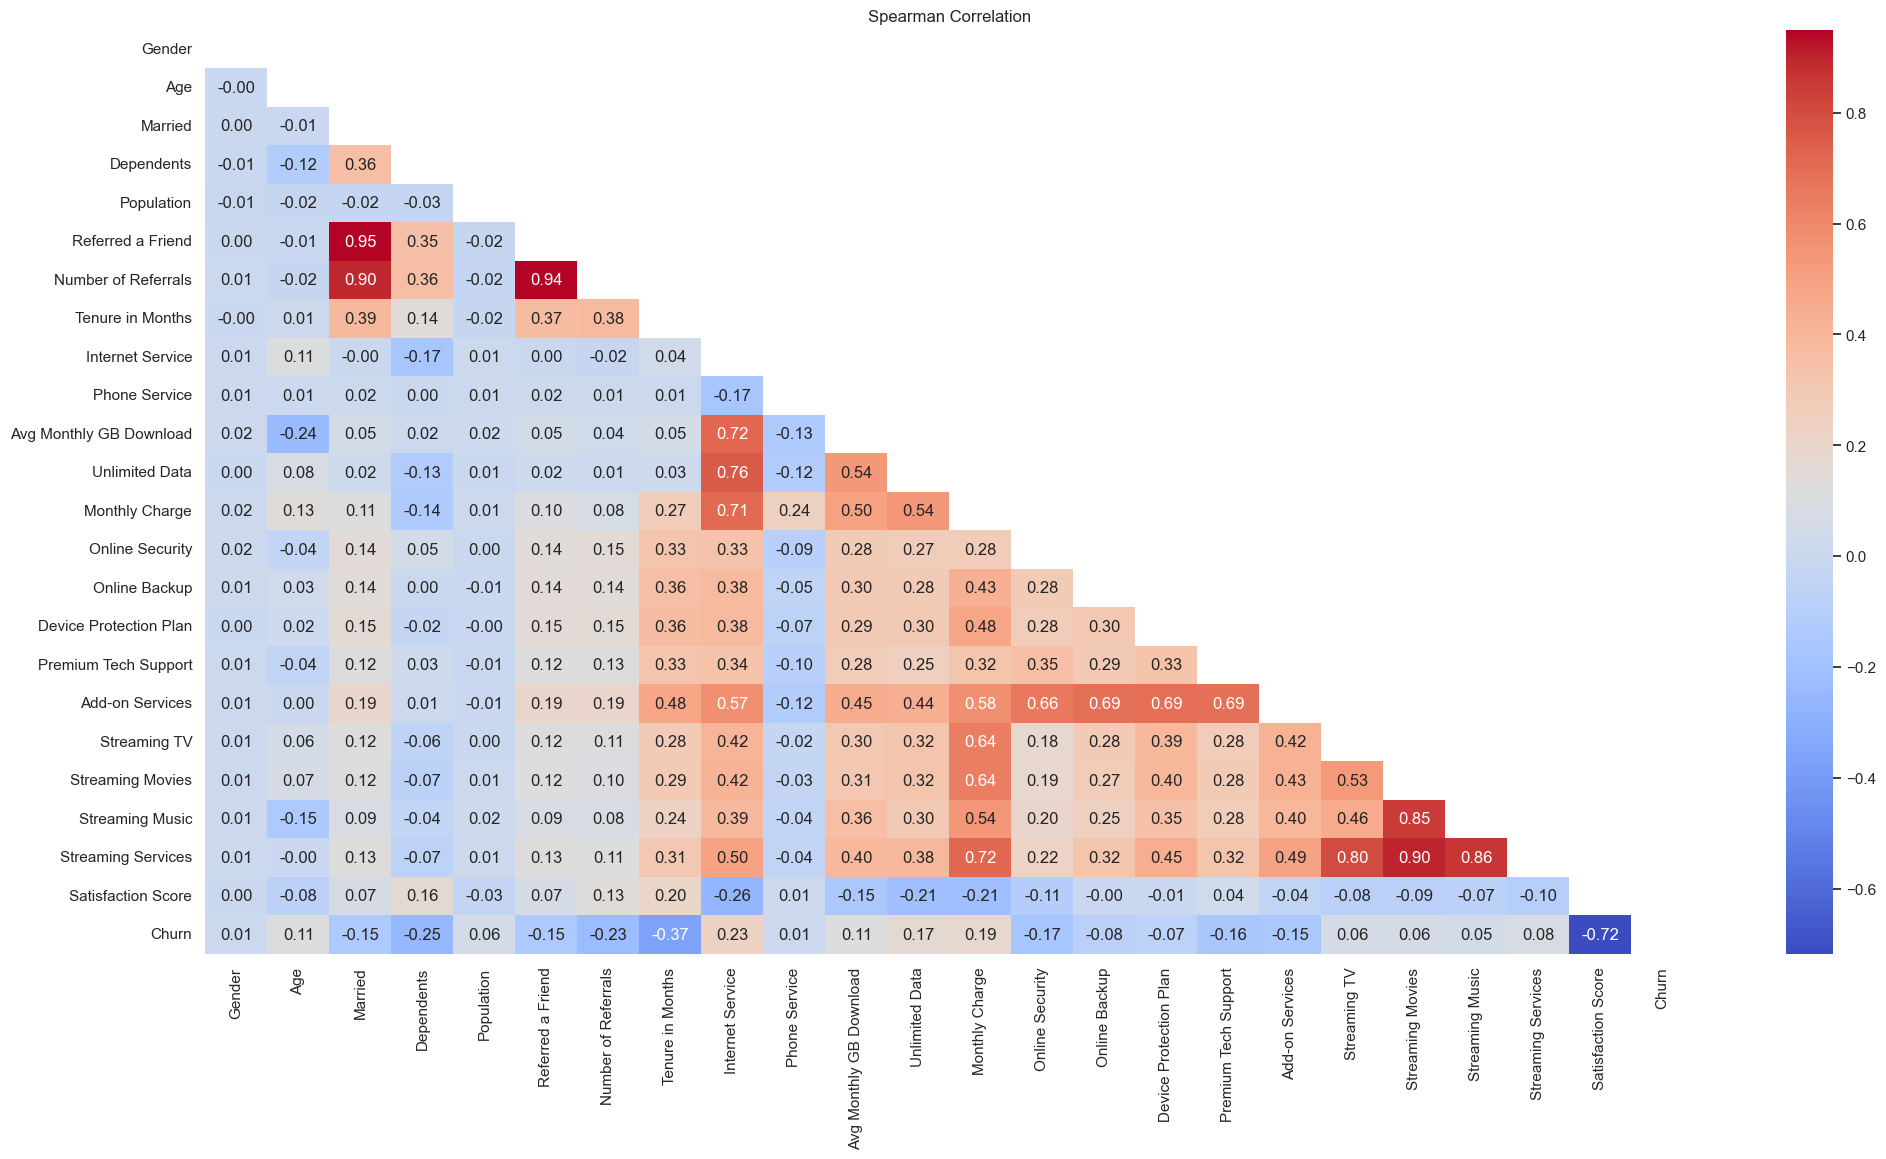

In [12]:
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['Senior Citizen', 'Number of Dependents', 'Zip Code', 'Monthly Extra Data Charge', 'Monthly Long Distance Charge'])

corr_spearman = numeric_df.corr(method='spearman')

mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

plt.figure(figsize=(24, 12))

sns.heatmap(corr_spearman, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Spearman Correlation')
plt.grid(False)

plt.show()

## 📌Insights

### **Churn Drivers**

- **Satisfaction Score (-0.72)**: The strongest negative correlation — happier customers stay.
- **Tenure (-0.37)**: Longer relationships reduce churn risk.
- **Dependents (-0.25)**: Families tend to stay loyal.
- **Number of Referrals (-0.23)**: Engaged customers who bring friends churn less.

### Additional Insights

- **Married → Referred a Friend (0.95)**: Married customers are much more likely to refer friends — social factor for engagement.
- **Streaming Movies → Streaming Music (0.85)**: Strong overlap.
- **Add-on Services** increase with **longer Tenure (0.48)** and if **Internet Service is active (0.57)** — clients tend to buy some extras.

---

# ⭐Satisfaction Score and Churning

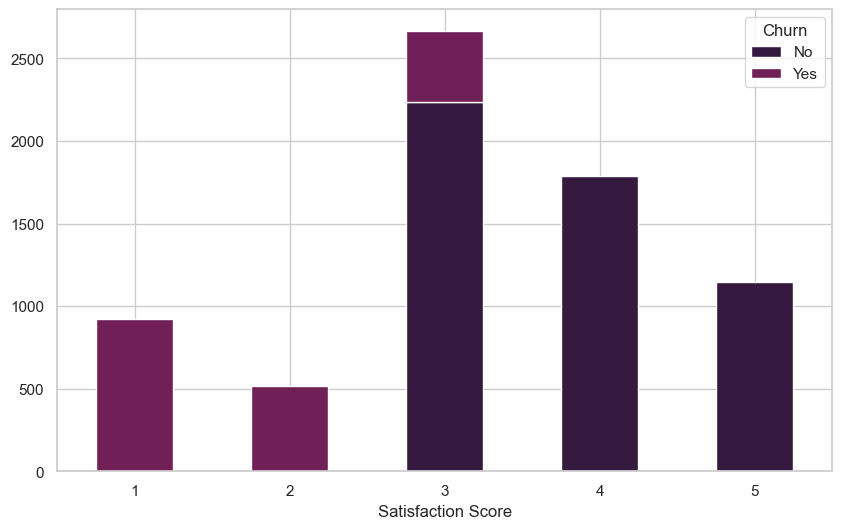

In [13]:
stacked_data = (
    df_eda.groupby(['Satisfaction Score', 'Churn'])
    .size()
    .unstack(fill_value=0)  
)

stacked_data.plot(
    kind='bar',
    stacked=True
)
plt.xticks(rotation=0)
plt.show()


While we observe a clear link between **Satisfaction Score** and churn — clients who rate us low are more likely to leave — the score itself is only a *reflection* of deeper reasons: pricing, hidden costs, service quality, relevance of offers.

To find **actionable drivers**, we focus directly on **churn behavior**, because:
- Churn is the final business outcome.
- The same factors that lower satisfaction also push customers to leave.
- This helps us identify what truly needs improvement: service features, pricing policy, contract conditions, extra fees or hidden charges.

In [ ]:
df = df.drop(columns=['Satisfaction Score'])
df_eda = df_eda.drop(columns=['Satisfaction Score'])

Gender  Age Senior Citizen Married Dependents  Number of Dependents  \
0   Male   78            Yes      No         No                     0   

          City  Zip Code  Population Referred a Friend  ...  \
0  Los Angeles     90022       68701                No  ...   

   Device Protection Plan  Premium Tech Support Add-on Services Streaming TV  \
0                     Yes                    No               1           No   

   Streaming Movies Streaming Music Streaming Services  Customer Status  \
0               Yes              No                  1          Churned   

   Churn                  Churn Reason  
0    Yes  Competitor offered more data  

[1 rows x 32 columns]

# 👥Demographic and Social Factors


## Age and Gender

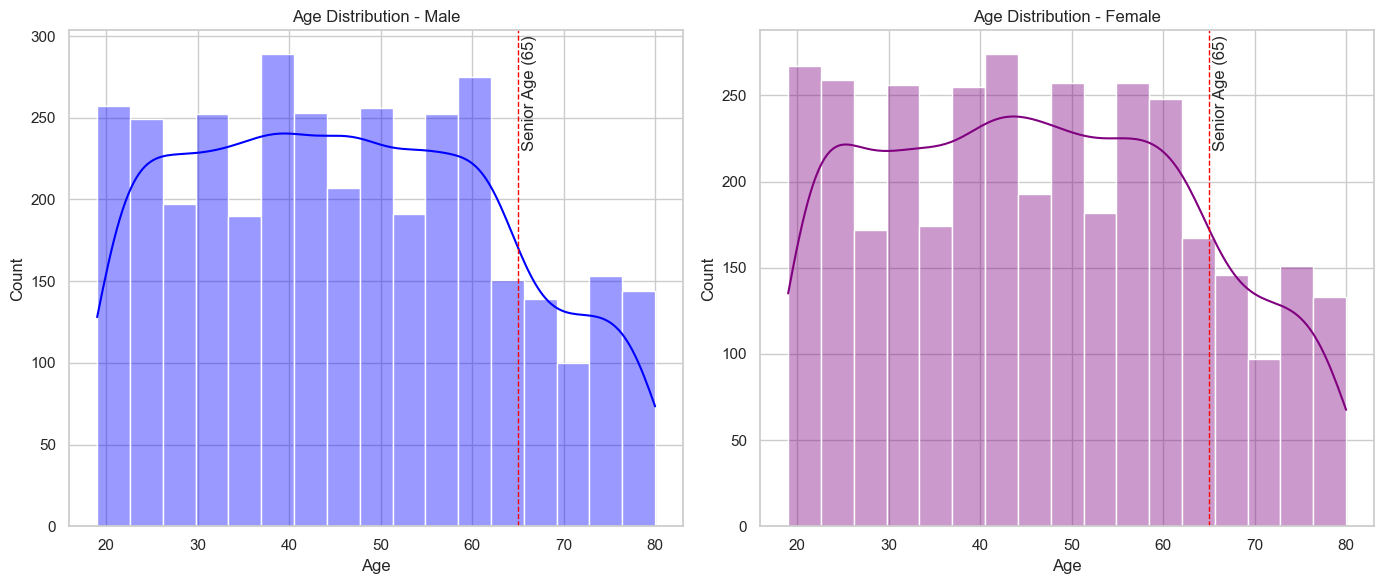

In [15]:
df_male = df_eda[df_eda['Gender'] == 'Male']
df_female = df_eda[df_eda['Gender'] == 'Female']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(
    data=df_male,
    x="Age",
    kde=True,
    alpha=0.4,
    color='blue',
    ax=axes[0]
)
axes[0].axvline(x=65, color='red', linestyle='--', linewidth=1, label='Senior Age')
axes[0].text(65 + 0.5, axes[0].get_ylim()[1]*0.99, 'Senior Age (65)', rotation=90, va='top')
axes[0].set_title('Age Distribution - Male')

sns.histplot(
    data=df_female,
    x="Age",
    kde=True,
    alpha=0.4,
    color='purple',
    ax=axes[1]
)
axes[1].axvline(x=65, color='red', linestyle='--', linewidth=1, label='Senior Age')
axes[1].text(65 + 0.5, axes[1].get_ylim()[1]*0.99, 'Senior Age (65)', rotation=90, va='top')
axes[1].set_title('Age Distribution - Female')

plt.tight_layout()
plt.show()

- Age shows a fairly even distribution up to retirement age.

- Noticeable drop around **50 years** for unknown reasons.
- Seniors form a smaller share overall.
- **No gender dominance** — men and women are evenly spread across all ages.

In [16]:
sns.histplot(data=df_eda, x="Age", hue='Churn', kde=False, alpha=0.4, palette=[sns.color_palette()[0], sns.color_palette()[3]])
plt.axvline(x=65, color='red', linestyle='--', linewidth=1, label='Senior Age')
plt.text(65 + 0.5, plt.ylim()[1]*0.99, 'Senior Age (65)', rotation=90, va='top')

plt.show()

- **Senior clients churn more often** — clear pattern.

- For pre-retirement age, churn share is relatively stable.

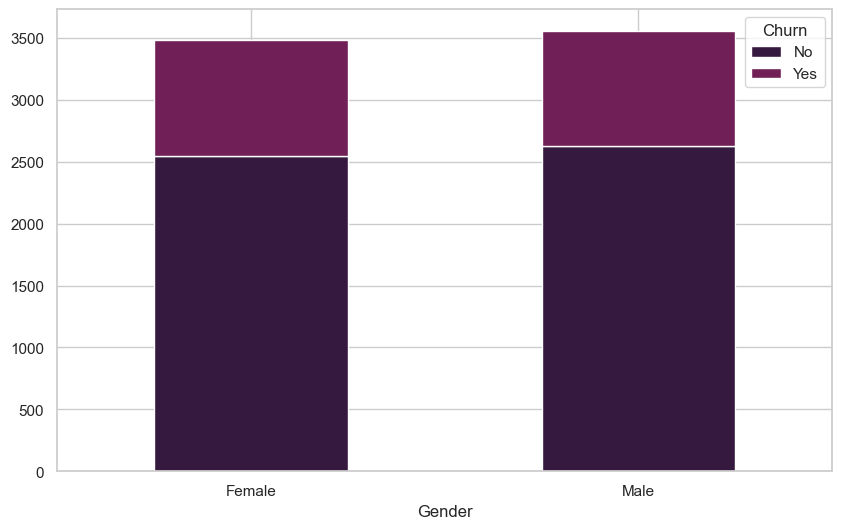

In [17]:
stacked_data = (
    df_eda.groupby(['Gender', 'Churn'])
    .size()
    .unstack(fill_value=0) 
)

stacked_data.plot(
    kind='bar',
    stacked=True
)
plt.xticks(rotation=0)
plt.show()

- No significant difference in churn between **men and women**.

- Gender distribution is nearly 50/50, churn share is balanced too.

## Married and Dependents

In [18]:
stacked_data = (
    df_eda
    .groupby(['Married', 'Churn'])
    .size()
    .unstack(fill_value=0)
)
churn_labels = stacked_data.columns.tolist()

ax = stacked_data.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)

for i in range(len(stacked_data)):
    total = stacked_data.iloc[i].sum()
    bottom = 0
    for label in churn_labels:
        val = stacked_data.iloc[i][label]
        pct = val / total * 100 if total != 0 else 0
        # show percent in the middle of each bar segment
        ax.text(i, bottom + val/2, f'{pct:.1f}%', ha='center', va='center', color='white', fontsize=10)
        bottom += val

plt.show()


- **Married customers** tend to churn less

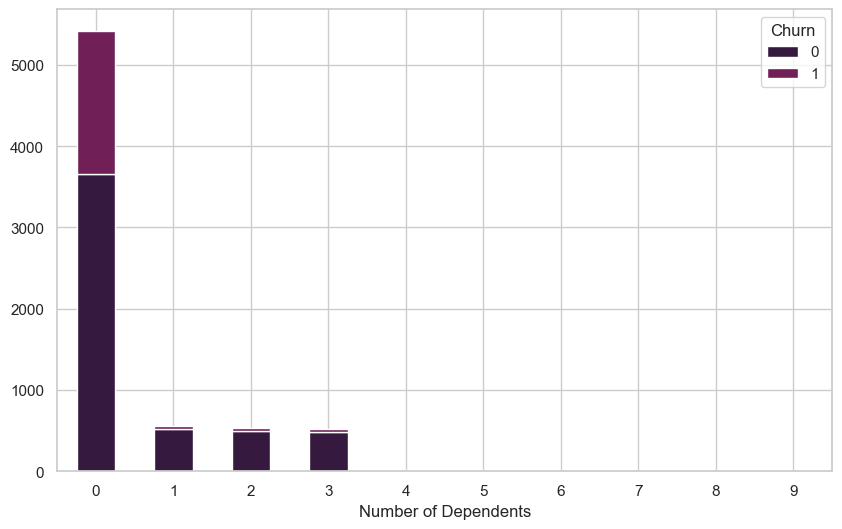

In [19]:
stacked_data = (
    df.groupby(['Number of Dependents', 'Churn'])
    .size()
    .unstack(fill_value=0) 
)

stacked_data.plot(
    kind='bar',
    stacked=True
)
plt.xticks(rotation=0)
plt.show()

- Customers **without dependents** are more likely to churn.

## Number of Referrals

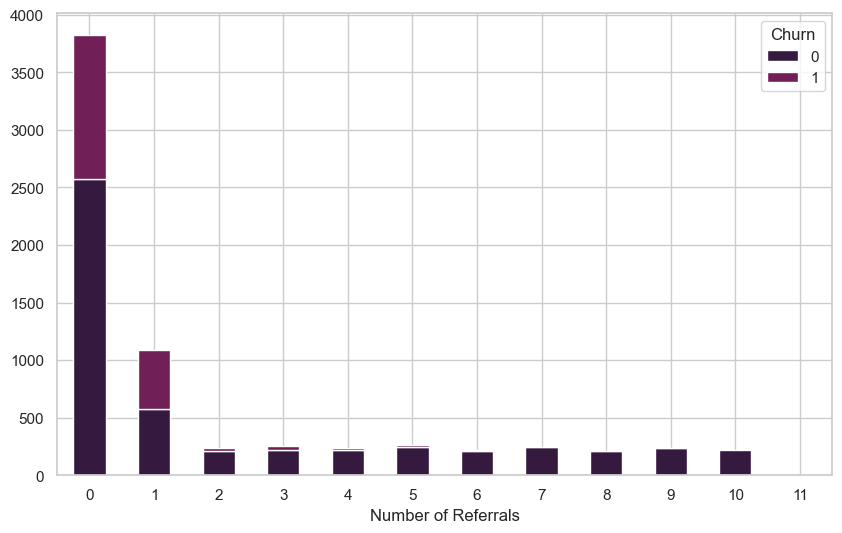

In [20]:
stacked_data = (
    df.groupby(['Number of Referrals', 'Churn'])
    .size()
    .unstack(fill_value=0) 
)

stacked_data.plot(
    kind='bar',
    stacked=True
)
plt.xticks(rotation=0)
plt.show()

- Customers with **no referrals or only few referral** are more likely to churn.

- Higher number of referrals → lower churn risk.

## 🔗Remember Correlation?

In [21]:
corr = df[['Number of Referrals', 'Number of Dependents', 'Married']].corr('spearman')

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1)
plt.title('Spearman Correlation')
plt.grid(False)

plt.show()

Above, we noticed that the **Number of Referrals** strongly correlates with the **Married** factor.
The next plot shows this clearly: **Unmarried people mostly have 0 referrals**, while married customers tend to refer more — probably because family ties encourage sharing services. 

👉 This link does **not** appear in the same way for **Dependents**, which means family status and actual household size may have different effects on loyalty.

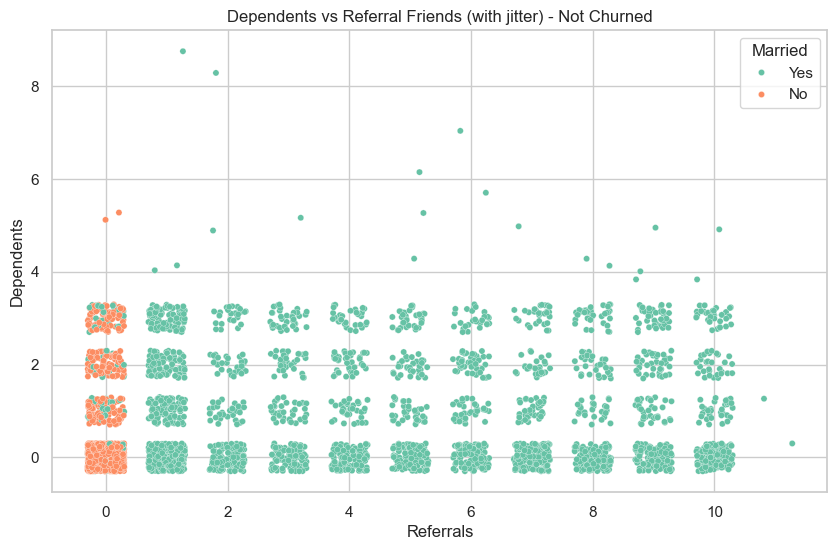

In [22]:

df_eda['Referrals'] = df['Number of Referrals'] + np.random.uniform(-0.3, 0.3, size=len(df))
df_eda['Dependents'] = df['Number of Dependents'] + np.random.uniform(-0.3, 0.3, size=len(df))

# Filter only customers who have not churned
not_churned = df_eda[df_eda['Churn'] == 'No']

sns.scatterplot(
    data=not_churned,
    x='Referrals',
    y='Dependents',
    hue='Married',
    linewidth=0.2,
    palette='Set2',
    s=20
)
plt.title('Dependents vs Referral Friends (with jitter) - Not Churned')
plt.show()

✅ For modeling, we should **keep only one** of these features to avoid redundancy.  
Since **Number of Referrals** gives more granular information than just Married/Not Married, we keep the numeric one.

## 📌 Insights

1. **Senior Citizens** have a higher churn rate — seniority is a clear factor.

2. **Gender** shows no clear impact on churn — not a useful predictor.  
3. **Married customers** and those with more **Dependents** tend to stay.  
4. **Number of Referrals** strongly correlates with being married, so it significantly impacts churn too.  

For modeling, we will keep **Number of Referrals** and **Number of Dependents** as numeric predictors, which provide more information than just a binary **Married** flag.

---

# 📍Location

## Map of churned clients

In [23]:
df_loc = pd.read_excel('data/Telco_customer_churn_location.xlsx')
df_status = pd.read_excel('data/Telco_customer_churn_status.xlsx')
df_loc = df_loc.merge(df_status[['Customer ID', 'Churn']], on='Customer ID', how='left')

m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

for _, row in df_loc[df_loc['Churn'] == 1].iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=1,
        color='brown',
        fill=True,
        fill_opacity=1,
        popup=f"Churn: {row['Churn']}"
    ).add_to(m)

all_locs = df_loc[['Latitude', 'Longitude']].values.tolist()
HeatMap(
    all_locs,
    radius=15,
    blur=10,
    gradient={
        0.0: 'white',
        0.2: '#fcebfc',
        0.5: '#de69f0',
        0.7: '#cd8cdb',
        1.0: '#480b85'
    },
    name='Customer Density'
).add_to(m)

folium.LayerControl().add_to(m)

m

- The map shows **customer density** (purple) and **churned clients** (brown).

- Naturally, areas with more customers have more churn — no unusual geographic patterns detected so far.

## Population and coverage by the company

In [24]:
city_stats = (
    df.groupby('City')
    .agg(
        Population=('Population', 'first'),
        Total=('Churn', 'count'),
        Churned=('Churn', 'sum')
    )
    .reset_index()
)

city_stats['Churn Rate (%)'] = (city_stats['Churned'] / city_stats['Total'] * 100).round(4)
city_stats['Coverage (%)'] = (city_stats['Total'] / city_stats['Population'] * 100).round(4)
city_stats = city_stats.sort_values('Churn Rate (%)', ascending=False).reset_index(drop=True)
city_stats


City  Population  Total  Churned  Churn Rate (%)  \
0            Eldridge         363      2        2           100.0   
1         Smith River        2020      4        4           100.0   
2               Twain          73      4        4           100.0   
3        Johannesburg         207      2        2           100.0   
4           Riverbank       16525      4        4           100.0   
...               ...         ...    ...      ...             ...   
1101            Glenn        1454      4        0             0.0   
1102        Glenhaven         175      4        0             0.0   
1103      San Quentin        6448      4        0             0.0   
1104  North Highlands       32202      4        0             0.0   
1105     Laguna Hills       48273      4        0             0.0   

      Coverage (%)  
0           0.5510  
1           0.1980  
2           5.4795  
3           0.9662  
4           0.0242  
...            ...  
1101        0.2751  
1102        2.2857  
1103        0.0620  
1104        0.0124  
1105        0.0083  

[1106 rows x 6 columns]

- Grouped customers by **City** to get:

  - **Population** (taken as the same for all rows within a city)
  - **Total number of clients**
  - **Number of churned clients**

- Calculated:
  - **Churn Rate (%)**: what share of each city’s clients left.
  - **Coverage (%)**: what share of the city’s population is covered in the dataset.

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KDE 1: Population vs Churn Rate
sns.kdeplot(
    data=city_stats,
    x='Population',
    y='Churn Rate (%)',
    fill=True,
    ax=axes[0],
    log_scale=(True, False)
)
axes[0].set_title('Population vs Churn Rate')

# KDE 2: Coverage vs Churn Rate
sns.kdeplot(
    data=city_stats,
    x='Coverage (%)',
    y='Churn Rate (%)',
    fill=True,
    ax=axes[1],
    log_scale=(True, False)
)
axes[1].set_title('Coverage vs Churn Rate')

plt.tight_layout()
plt.show()


- No clear link: both big and small cities can have high churn.

- Coverage also shows no strict pattern.

In [26]:
city_stats['Population_Bin'] = pd.cut(
    city_stats['Population'],
    bins=[0, 1000, 10000, 200000],
    labels=['Low', 'Medium', 'High']
)

city_stats.groupby('Population_Bin').agg({
    'City': 'count',
    'Churn Rate (%)': 'mean',
    'Coverage (%)': 'mean',
    'Total': 'sum',
    'Churned': 'sum'
})


City  Churn Rate (%)  Coverage (%)  Total  Churned
Population_Bin                                                    
Low              292       24.055365      2.360682   1174      280
Medium           370       23.740410      0.159756   1594      376
High             444       24.831345      0.035045   4275     1213

- Grouped cities into **Low**, **Medium**, and **High Population** bins.

- **Churn Rate (%)** is very similar across all city sizes (~24%).

In [27]:
city_stats['Coverage_bin'] = pd.cut(
    city_stats['Coverage (%)'],
    bins=[0, 1, 10, 50, 100],
    labels=['0-1%', '1-10%', '5-50%', '50-100%']
)

coverage_grouped = city_stats.groupby('Coverage_bin').agg({
    'City': 'count',
    'Churn Rate (%)': 'mean',
    'Population': 'mean',
    'Total': 'sum',
    'Churned': 'sum'
}).reset_index()

coverage_grouped


Coverage_bin  City  Churn Rate (%)    Population  Total  Churned
0         0-1%   947       24.363677  16943.620908   6394     1715
1        1-10%   148       23.845720    219.533784    598      144
2        5-50%    10       21.166670     30.100000     41        8
3      50-100%     1       20.000000     11.000000     10        2


- **Coverage Bins**:
  - **0–1%**: Most cities — very low market reach, churn ~24%.
  - **1–10%**: Medium coverage, churn stays ~24%.
  - **5–50%**: Rare cases, slight drop in churn (~21%).
  - **50–100%**: Outliers — happens only in tiny towns, not meaningful.

- Market coverage does **not** significantly impact churn — the few high-coverage cases are tiny towns and not representative.

## Priority Cities

In [28]:

bins = [0, 5, 10, 50, 200, city_stats['Total'].max()]
labels = ['1-5', '5-10', '10-50', '50-200', '200+']

city_stats['Customer_Bin'] = pd.cut(city_stats['Total'], bins=bins, labels=labels)


grouped = (
    city_stats
    .groupby('Customer_Bin')
    .agg(
        Cities = ('City', 'count'),
        Avg_Population=('Population', 'mean'),
        Avg_Churn_Rate=('Churn Rate (%)', 'mean'),
        Total = ('Total', 'sum'),
        Churned=('Churned', 'sum')
    )
    .reset_index()
)

grouped


Customer_Bin  Cities  Avg_Population  Avg_Churn_Rate  Total  Churned
0          1-5     948    11774.078059       23.980309   3876      924
1         5-10      78    29413.782051       25.659338    668      169
2        10-50      71    31518.521127       25.696932   1373      370
3       50-200       7    40127.571429       26.065529    548      143
4         200+       2    51801.500000       45.766750    578      263


- Most bins (1-200 customers) show **stable churn around 24-26%**.

- 200+ customers stands out with a **much higher churn rate ~46%**.
  
💡 **Next step**: Investigate the high churn in the 2 largest cities where the company has the most clients.

In [29]:
city_stats.sort_values('Total', ascending=False)[:2]

City  Population  Total  Churned  Churn Rate (%)  Coverage (%)  \
315  Los Angeles       68701    293       78         26.6212        0.4265   
49     San Diego       34902    285      185         64.9123        0.8166   

    Population_Bin Coverage_bin Customer_Bin  
315           High         0-1%         200+  
49            High         0-1%         200+

- San Diego stands out — **65% churn rate**

💡 **Next step**: Focus on cities with **above "allowed" churn (>29%)**, sorted by **where we have the most customers** — these are the locations where churn hurts us most.

In [30]:
filtered = city_stats[city_stats['Churn Rate (%)'] > 29]
filtered_sorted = filtered.sort_values(['Total'], ascending=[False])
top5 = filtered_sorted.head(5)
top5

City  Population  Total  Churned  Churn Rate (%)  Coverage (%)  \
49       San Diego       34902    285      185         64.9123        0.8166   
308  San Francisco       28998    104       31         29.8077        0.3586   
299      Escondido       48690     51       16         31.3725        0.1047   
51       Fallbrook       42239     43       26         60.4651        0.1018   
297       Glendale       21990     40       13         32.5000        0.1819   

    Population_Bin Coverage_bin Customer_Bin  
49            High         0-1%         200+  
308           High         0-1%       50-200  
299           High         0-1%       50-200  
51            High         0-1%        10-50  
297           High         0-1%        10-50

In [31]:
top5_churned_sum = top5['Churned'].sum()
total_churned_state = df['Churn'].sum()
percent_top5_churned = (top5_churned_sum / total_churned_state) * 100

print(f"{percent_top5_churned.round(2)} %")

14.5 %


Here’s what we see:  

- A cluster of large cities — **San Diego, San Francisco, Escondido, Fallbrook, Glendale** — all have **churn rates above 29% and have alot of company's clients**.

- These cities making up **14.5% of all churned customers**.  
- High churn here *might signal* competitive pressure, pricing issues, or local service problems.


## 📌 Insights

- **Location itself** does not directly impact churn — there is no clear correlation between population or coverage and churn rate.

- However, **some cities show unusually high churn** — this may be driven by local competition or specific regional issues. These regions need deeper marketing review.

---

# 💵Contract Info

## Tenure

In [32]:

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=df_eda, x="Tenure in Months", kde=True, alpha=0.4, ax=axes[0])
axes[0].set_title('Full distribution of Tenure in Months')

sns.histplot(data=df_eda[df_eda['Churn'] == 'Yes'], x="Tenure in Months", kde=True, color=palette[3],  alpha=0.4, ax=axes[1])
axes[1].set_title('Distribution of Tenure in Months for Churned Customers')

plt.tight_layout()
plt.show()




- Churn distribution is heavily left-skewed — most customers leave within the first few months.

- Clear negative correlation: longer tenure strongly reduces churn risk.
- Early months are critical for customer retention efforts.

## Contract Type

In [33]:
sns.histplot(data=df_eda, x='Contract', hue='Churn', multiple='stack')

<Axes: xlabel='Contract', ylabel='Count'>


- Contract type clearly impacts churn.

- Customers on month-to-month plans churn significantly more often.
- Longer-term contracts correlate with higher retention.

## Additional Charges

In [34]:
bins = [-0.01, 0, 20, 50, 100]
labels = ['0 (No Extra)', '0-20', '20-50', '50-100']

df['Extra_Charge_Bin'] = pd.cut(df['Monthly Extra Data Charge'], bins=bins, labels=labels)

extra_bin_stats = (
    df.groupby('Extra_Charge_Bin')
    .agg(
        Total=('Churn', 'count'),
        Churned=('Churn', 'sum')
    )
    .reset_index()
)

extra_bin_stats['Churn Rate (%)'] = (extra_bin_stats['Churned'] / extra_bin_stats['Total'] * 100).round(2)

z = norm.ppf(0.975)  # 95% confidence interval

extra_bin_stats['p'] = extra_bin_stats['Churn Rate (%)'] / 100
extra_bin_stats['se'] = np.sqrt(extra_bin_stats['p'] * (1 - extra_bin_stats['p']) / extra_bin_stats['Total'])

extra_bin_stats['CI Lower (%)'] = ((extra_bin_stats['p'] - z * extra_bin_stats['se']) * 100).round(2)
extra_bin_stats['CI Upper (%)'] = ((extra_bin_stats['p'] + z * extra_bin_stats['se']) * 100).round(2)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=extra_bin_stats,
    x='Extra_Charge_Bin',
    y='Churn Rate (%)',
    palette='rocket'
)

plt.title('Churn Rate by Monthly Extra Data Charge Bin', fontsize=14)
plt.xlabel('Monthly Extra Data Charge Bin ($)', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.ylim(0, extra_bin_stats['CI Upper (%)'].max() + 10)

# Draw confidence intervals as whiskers
for index, row in extra_bin_stats.iterrows():
    ci_lower = row['CI Lower (%)']
    ci_upper = row['CI Upper (%)']
    ax.plot([index, index], [ci_lower, ci_upper], color='black', linewidth=0.5)
    ax.plot([index - 0.1, index + 0.1], [ci_lower, ci_lower], color='black', linewidth=0.5)
    ax.plot([index - 0.1, index + 0.1], [ci_upper, ci_upper], color='black', linewidth=0.5)

for index, row in extra_bin_stats.iterrows():
    plt.text(index, row['Churn Rate (%)'] + 1, f"{row['Churn Rate (%)']}%", ha='center', fontsize=10)

plt.show()

extra_bin_stats


Extra_Charge_Bin  Total  Churned  Churn Rate (%)       p        se  \
0     0 (No Extra)   6315     1630           25.81  0.2581  0.005507   
1             0-20    706      229           32.44  0.3244  0.017619   
2            20-50     14        6           42.86  0.4286  0.132261   
3           50-100      8        4           50.00  0.5000  0.176777   

   CI Lower (%)  CI Upper (%)  
0         24.73         26.89  
1         28.99         35.89  
2         16.94         68.78  
3         15.35         84.65

- While higher **extra charges** are associated with greater churn risk, we have limited data for customers with very high extra charges. 

- The confidence intervals for these groups are extremely wide, so we cannot guarantee that extra charges are a reliable predictor of churn.

- The most of clients has no extra charge.

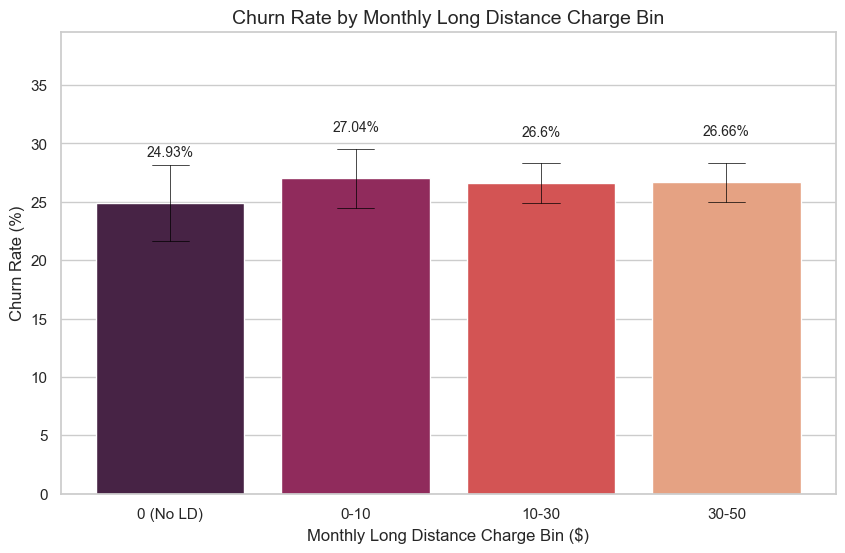

Long_Distance_Charge_Bin  Total  Churned  Churn Rate (%)       p        se  \
0                0 (No LD)    682      170           24.93  0.2493  0.016565   
1                     0-10   1187      321           27.04  0.2704  0.012892   
2                    10-30   2571      684           26.60  0.2660  0.008714   
3                    30-50   2603      694           26.66  0.2666  0.008667   

   CI Lower (%)  CI Upper (%)  
0         21.68         28.18  
1         24.51         29.57  
2         24.89         28.31  
3         24.96         28.36

In [35]:
bins = [-0.01, 0, 10, 30, 50]
labels = ['0 (No LD)', '0-10', '10-30', '30-50']

df['Long_Distance_Charge_Bin'] = pd.cut(df['Monthly Long Distance Charge'], bins=bins, labels=labels)

ld_bin_stats = (
    df.groupby('Long_Distance_Charge_Bin')
    .agg(
        Total=('Churn', 'count'),
        Churned=('Churn', 'sum')
    )
    .reset_index()
)

ld_bin_stats['Churn Rate (%)'] = (ld_bin_stats['Churned'] / ld_bin_stats['Total'] * 100).round(2)

z = norm.ppf(0.975)  # 95% confidence interval

ld_bin_stats['p'] = ld_bin_stats['Churn Rate (%)'] / 100
ld_bin_stats['se'] = np.sqrt(ld_bin_stats['p'] * (1 - ld_bin_stats['p']) / ld_bin_stats['Total'])

ld_bin_stats['CI Lower (%)'] = ((ld_bin_stats['p'] - z * ld_bin_stats['se']) * 100).round(2)
ld_bin_stats['CI Upper (%)'] = ((ld_bin_stats['p'] + z * ld_bin_stats['se']) * 100).round(2)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=ld_bin_stats,
    x='Long_Distance_Charge_Bin',
    y='Churn Rate (%)',
    palette='rocket'
)

plt.title('Churn Rate by Monthly Long Distance Charge Bin', fontsize=14)
plt.xlabel('Monthly Long Distance Charge Bin ($)', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.ylim(0, ld_bin_stats['CI Upper (%)'].max() + 10)

# Draw confidence intervals as whiskers
for index, row in ld_bin_stats.iterrows():
    ci_lower = row['CI Lower (%)']
    ci_upper = row['CI Upper (%)']
    ax.plot([index, index], [ci_lower, ci_upper], color='black', linewidth=0.5)
    ax.plot([index - 0.1, index + 0.1], [ci_lower, ci_lower], color='black', linewidth=0.5)
    ax.plot([index - 0.1, index + 0.1], [ci_upper, ci_upper], color='black', linewidth=0.5)

for index, row in ld_bin_stats.iterrows():
    plt.text(index, row['Churn Rate (%)'] + 4, f"{row['Churn Rate (%)']}%", ha='center', fontsize=10)

plt.show()
ld_bin_stats


- Customers with **no long distance charges** have slightly lower churn rate.

- The confidence intervals overlap, so we cannot conclude there is a significant impact.

- The majority of clients have some long distance charges.

## 📌 Insights

1. Most customers leave within the first few months, so **tenure** is a very important feature.  

2. Customers on **month-to-month plans** churn significantly more often — contract type clearly impacts churn.  
3. Extra charges may not be a reliable predictor due to small sample sizes, but they make sense logically and can be included as additional features.  
4. **Long distance charges** do not have a significant impact on churn.
---

# 📡Services

## Main Services

In [36]:
print("Customers who dont use any main service:")
len(df[(df['Internet Service'] == 0) & (df['Phone Service'] == 0)])


Customers who dont use any main service:


0

In [37]:
df_eda['Internet_Phone'] = df_eda['Internet Service'] + " / " + df_eda['Phone Service']

combinations = ["Yes / Yes", "Yes / No", "No / Yes"]

summary = (
    df_eda[df_eda['Internet_Phone'].isin(combinations)]
    .groupby('Internet_Phone')
    .agg(
        total_customers=('Churn', 'count'),
        churned_customers=('Churn', lambda x: (x == 'Yes').sum())
    )
    .reset_index()
)

summary['churn_rate'] = summary['churned_customers'] / summary['total_customers'] * 100

z = norm.ppf(0.975)
summary['p'] = summary['churned_customers'] / summary['total_customers']
summary['se'] = np.sqrt(summary['p'] * (1 - summary['p']) / summary['total_customers'])
summary['ci_lower'] = (summary['p'] - z * summary['se']) * 100
summary['ci_upper'] = (summary['p'] + z * summary['se']) * 100

x = np.arange(len(summary))
fig, ax = plt.subplots(figsize=(8, 6))

palette = sns.color_palette('rocket', n_colors=len(summary))
rects = ax.bar(x, summary['churn_rate'], color=palette, yerr=[
    summary['churn_rate'] - summary['ci_lower'],
    summary['ci_upper'] - summary['churn_rate']
], capsize=5, alpha=0.8)

ax.set_xlabel('Internet / Phone')
ax.set_ylabel('Churn Rate (%)')
ax.set_title('Churn Rate by Internet / Phone Combination')
ax.set_xticks(x)
ax.set_xticklabels(summary['Internet_Phone'])

for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%', xy=(rect.get_x() + rect.get_width() / 2-0.2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


- Clients using **only phone services** churn at around **8%**.

- Clients using **only internet services** churn at around **25%**.
- If both services are active, **risks add up** — combined churn rate is about **33%**.

- **The confidence intervals do not overlap**, indicating that the type of service (Internet/Phone) has a significant impact on customer churn.

In [38]:
combinations = [
    ('No', 'Yes'),   # Only phone
    ('Yes', 'No'),   # Only internet
    ('Yes', 'Yes')   # Both
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, combo in zip(axes.flatten(), combinations):
    internet_val, phone_val = combo
    subset = df_eda[(df_eda['Internet Service'] == internet_val) & (df_eda['Phone Service'] == phone_val)]
    sns.histplot(
        data=subset,
        x='Monthly Charge',
        kde=True,
        hue='Churn',
        ax=ax,
        legend=True
    )
    ax.set_title(f'Internet: {internet_val}, Phone: {phone_val}', fontsize=14)
    ax.set_xlabel('Monthly Charge ($)', fontsize=12)  # Fixed label typo
    ax.set_ylabel('Count', fontsize=12)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


- The price distributions for service combinations are quite similar, which means there is no significant relationship between the tariff price and churn.

## Avg Monthly GB Download

<Axes: xlabel='Avg Monthly GB Download', ylabel='Count'>

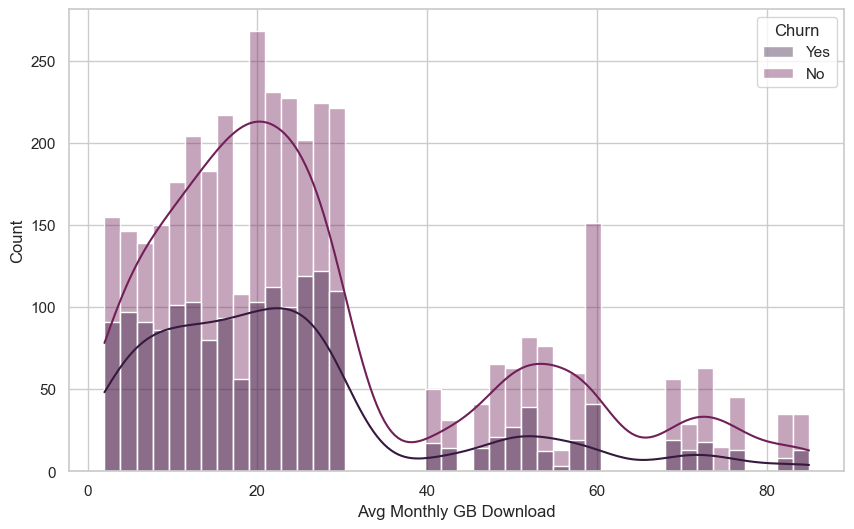

In [39]:
sns.histplot(data=df_eda[df_eda['Internet Service'] == 'Yes'], x="Avg Monthly GB Download", hue = 'Churn', kde = True, alpha=0.4)


- The distributions are similar, and there is no noticeable relationship between the amount of used GB and customer churn.

## Extra Services

In [40]:
addon_features = [
    "Online Security",
    "Online Backup",
    "Device Protection Plan",
    "Premium Tech Support"
]

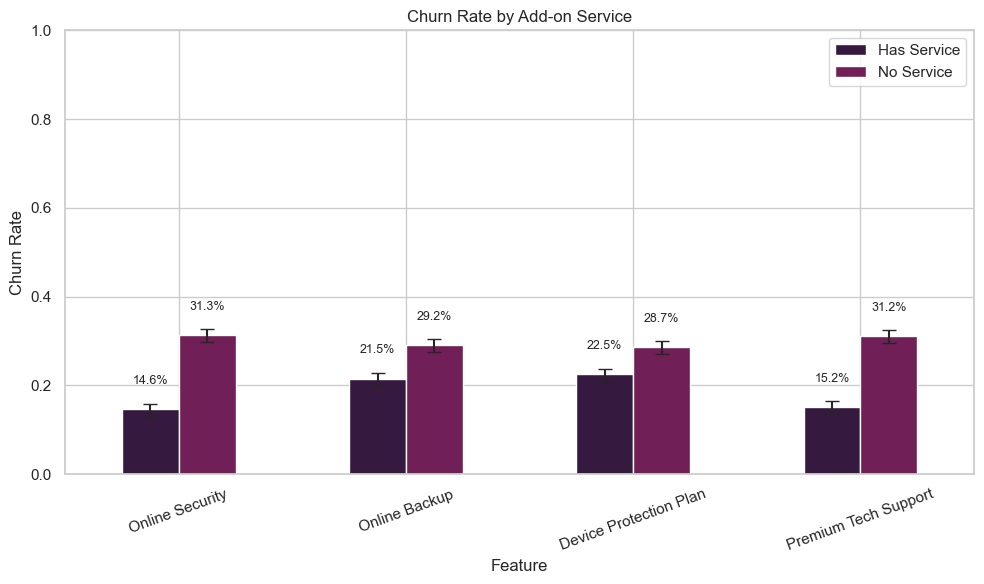

In [41]:
df_bin = df[addon_features].replace({'Yes': 1, 'No': 0})
df_bin['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

churn_data = []
z = norm.ppf(0.975)

for feat in addon_features:
    has_service = df_bin[df_bin[feat] == 1]
    no_service = df_bin[df_bin[feat] == 0]

    p1 = has_service['Churn'].mean()
    n1 = len(has_service)
    se1 = np.sqrt(p1 * (1 - p1) / n1)
    ci1_lower = p1 - z * se1
    ci1_upper = p1 + z * se1

    p0 = no_service['Churn'].mean()
    n0 = len(no_service)
    se0 = np.sqrt(p0 * (1 - p0) / n0)
    ci0_lower = p0 - z * se0
    ci0_upper = p0 + z * se0

    churn_data.append({
        'Feature': feat,
        'Has Service': p1,
        'Has CI Lower': ci1_lower,
        'Has CI Upper': ci1_upper,
        'No Service': p0,
        'No CI Lower': ci0_lower,
        'No CI Upper': ci0_upper
    })

churn_df = pd.DataFrame(churn_data).set_index('Feature')

ax = churn_df[['Has Service', 'No Service']].plot(kind='bar', figsize=(10, 6), yerr=[
    [
        churn_df['Has Service'] - churn_df['Has CI Lower'],
        churn_df['No Service'] - churn_df['No CI Lower']
    ],
    [
        churn_df['Has CI Upper'] - churn_df['Has Service'],
        churn_df['No CI Upper'] - churn_df['No Service']
    ]
], capsize=5)

ax.set_ylabel('Churn Rate')
ax.set_title('Churn Rate by Add-on Service')
ax.set_ylim(0, 1)
ax.legend(title='')
plt.xticks(rotation=20)

for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.1f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()+0.05),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

- Customers who have subscribed to **the online security service** and **premium technical support** churn at half the rate compared to those who do not have these services. 

- This indicates **a significant retention benefit** associated with these premium service offerings, since the confidence intervals do not overlap

- All add-on services are associated with lower churn rates for customers.

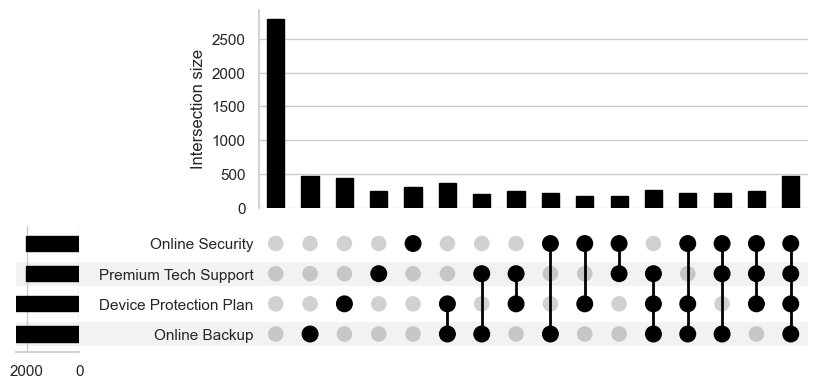

In [42]:
upset_data = from_indicators(addon_features, df[addon_features].replace({1: True, 0: False}))
UpSet(upset_data).plot()
plt.show()

Distribution of Customers by Service Combinations

- Most clients have no additional services.

- Only Online Backup or only Device Protection Plan are popular individually.
- Having all four services simultaneously is also quite popular.


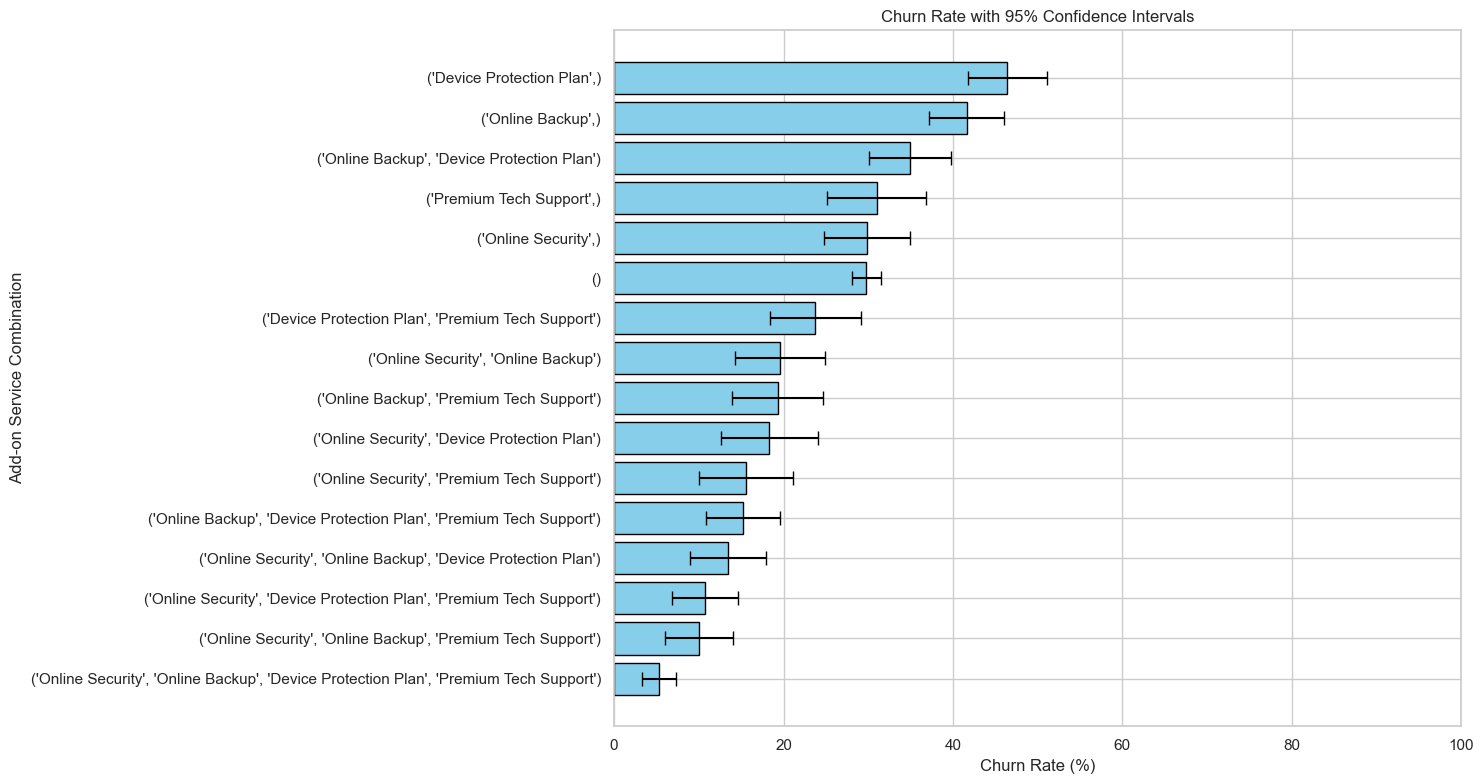

In [43]:
df['membership'] = df[addon_features].replace({1: True, 0: False}).apply(
    lambda row: tuple(col for col, val in row.items() if val), axis=1
)

grouped = df.groupby('membership')['Churn'].agg(['count', 'sum']).reset_index()
grouped['churn_rate'] = grouped['sum'] / grouped['count']

z = norm.ppf(0.975)

grouped['SE'] = np.sqrt(grouped['churn_rate'] * (1 - grouped['churn_rate']) / grouped['count'])
grouped['CI_lower'] = (grouped['churn_rate'] - z * grouped['SE']).clip(lower=0) * 100
grouped['CI_upper'] = (grouped['churn_rate'] + z * grouped['SE']).clip(upper=1) * 100
grouped['churn_rate'] = grouped['churn_rate'] * 100

grouped['error'] = grouped['CI_upper'] - grouped['churn_rate']

grouped_sorted = grouped.sort_values('churn_rate', ascending=True)

fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(
    grouped_sorted['membership'].astype(str),
    grouped_sorted['churn_rate'],
    xerr=grouped_sorted['error'],
    capsize=5,
    color='skyblue',
    edgecolor='black'
)

ax.set_xlabel('Churn Rate (%)')
ax.set_ylabel('Add-on Service Combination')
ax.set_title('Churn Rate with 95% Confidence Intervals')
ax.set_xlim(0,100)

plt.tight_layout()
plt.show()


- Confidence intervals are wide (~10%) because sample sizes for each service combination are small.  

- Individual services like **Premium Support** or **Online Security** have churn rates overlapping with customers having no extra services.  
- However, customers with these two additional services tend to show a lower churn rate in combinations overall.  

**Next step:**  
- Investigate if the **total number of services** shows a clear trend with churn.  
- Alternatively, focus on the two most impactful features: **Premium Support** and **Online Security**.


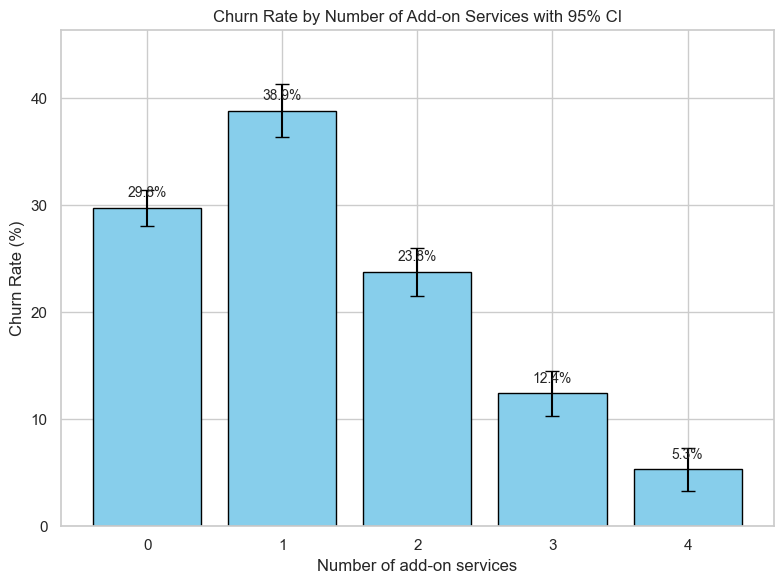

In [44]:
grouped = df.groupby('Add-on Services')['Churn'].agg(['count', 'mean']).reset_index()
grouped['churn_rate'] = grouped['mean'] * 100

z = norm.ppf(0.975)
grouped['SE'] = np.sqrt(grouped['mean'] * (1 - grouped['mean']) / grouped['count'])
grouped['CI_lower'] = (grouped['mean'] - z * grouped['SE']).clip(lower=0) * 100
grouped['CI_upper'] = (grouped['mean'] + z * grouped['SE']).clip(upper=1) * 100
grouped['error'] = grouped['CI_upper'] - grouped['churn_rate']


plt.figure(figsize=(8,6))
plt.bar(grouped['Add-on Services'], grouped['churn_rate'], 
        yerr=grouped['error'], capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Number of add-on services')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Number of Add-on Services with 95% CI')
plt.ylim(0, grouped['CI_upper'].max() + 5)

for i, row in grouped.iterrows():
    plt.text(row['Add-on Services'], row['churn_rate'] + 1, f"{row['churn_rate']:.1f}%", 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

- This is not a linear relationship, so we will focus on predicting churn based on impact of services individually, rather than the total number of services.

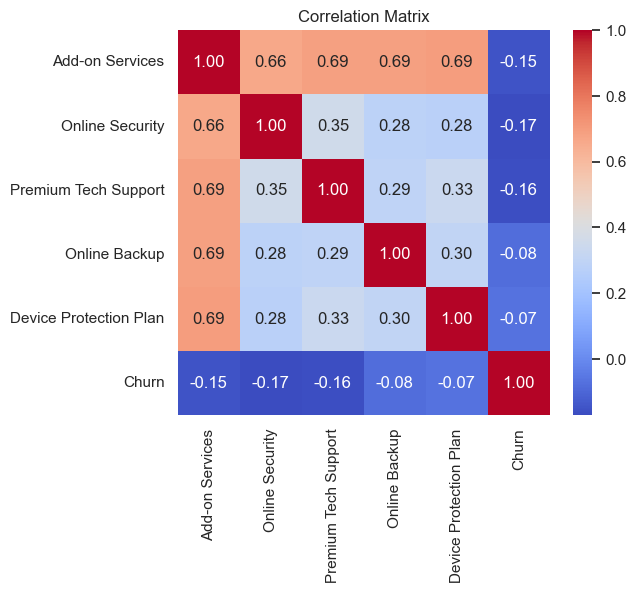

In [45]:
cols = ['Add-on Services', 'Online Security', 'Premium Tech Support', "Online Backup",
    "Device Protection Plan", 'Churn']

corr_matrix = df[cols].corr(method='spearman') 

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

- The correlation matrix shows that the **total number of services** has a lower correlation with churn than **Online Security** and **Premium Support** individually.  

- The other two services have much lower correlation as well.  
- Therefore, for modeling, we will use only the **two most impactful features**.


## Streaming Services

In [46]:
streaming_features = [
    "Streaming TV",
    "Streaming Movies",
    "Streaming Music"
]

- To avoid mixing customers who cannot use streaming services because they do not have internet service, we will exclude them from this part of the analysis.

In [47]:
df_bin = df[streaming_features + ['Internet Service']].replace({'Yes': 1, 'No': 0})
df_bin['Churn'] = df['Churn']
df_bin = df_bin[df_bin['Internet Service'] == 1]

churn_data = []
z = norm.ppf(0.975)

for feat in streaming_features:
    has_service = df_bin[df_bin[feat] == 1]
    no_service = df_bin[df_bin[feat] == 0]

    p1 = has_service['Churn'].mean()
    n1 = len(has_service)
    se1 = np.sqrt(p1 * (1 - p1) / n1)
    ci1_lower = p1 - z * se1
    ci1_upper = p1 + z * se1

    p0 = no_service['Churn'].mean()
    n0 = len(no_service)
    se0 = np.sqrt(p0 * (1 - p0) / n0)
    ci0_lower = p0 - z * se0
    ci0_upper = p0 + z * se0

    churn_data.append({
        'Feature': feat,
        'Has Service': p1,
        'Has CI Lower': ci1_lower,
        'Has CI Upper': ci1_upper,
        'No Service': p0,
        'No CI Lower': ci0_lower,
        'No CI Upper': ci0_upper
    })

churn_df = pd.DataFrame(churn_data).set_index('Feature')

ax = churn_df[['Has Service', 'No Service']].plot(kind='bar', figsize=(10, 6), yerr=[
    [
        churn_df['Has Service'] - churn_df['Has CI Lower'],
        churn_df['No Service'] - churn_df['No CI Lower']
    ],
    [
        churn_df['Has CI Upper'] - churn_df['Has Service'],
        churn_df['No CI Upper'] - churn_df['No Service']
    ]
], capsize=5)

ax.set_ylabel('Churn Rate')
ax.set_title('Churn Rate by Add-on Service')
ax.set_ylim(0, 1)
ax.legend(title='')
plt.xticks(rotation=20)

for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.1f}%',
                (p.get_x() + p.get_width() / 2, p.get_height()+0.05),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

- We see that no individual streaming service has a significant impact on churn.  

- The confidence intervals are close to each other, so we cannot confirm a strong effect.

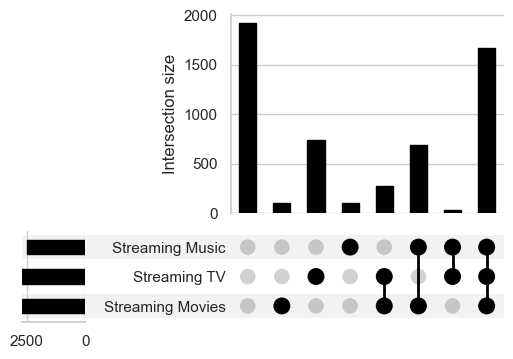

In [48]:
upset_data = from_indicators(streaming_features, df_bin[streaming_features].replace({1: True, 0: False}))

UpSet(upset_data).plot()
plt.show()

Distribution of Customers by Streaming Services

- Most customers either do **not use any streaming services** or have **all three streaming services connected**.

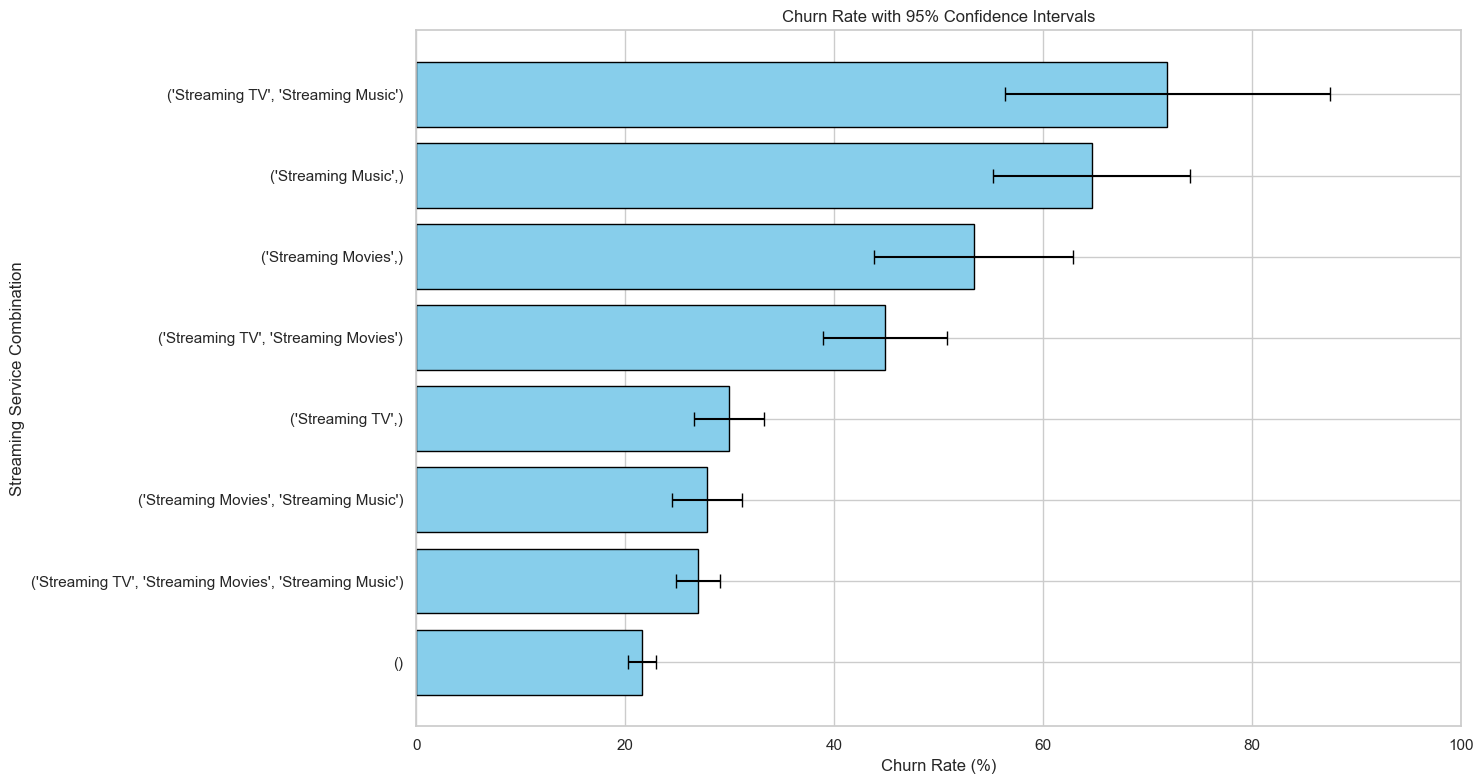

In [49]:
df['membership'] = df[streaming_features].replace({1: True, 0: False}).apply(
    lambda row: tuple(col for col, val in row.items() if val), axis=1
)

grouped = df.groupby('membership')['Churn'].agg(['count', 'sum']).reset_index()
grouped['churn_rate'] = grouped['sum'] / grouped['count']

z = norm.ppf(0.975)

grouped['SE'] = np.sqrt(grouped['churn_rate'] * (1 - grouped['churn_rate']) / grouped['count'])
grouped['CI_lower'] = (grouped['churn_rate'] - z * grouped['SE']).clip(lower=0) * 100
grouped['CI_upper'] = (grouped['churn_rate'] + z * grouped['SE']).clip(upper=1) * 100
grouped['churn_rate'] = grouped['churn_rate'] * 100

grouped['error'] = grouped['CI_upper'] - grouped['churn_rate']

grouped_sorted = grouped.sort_values('churn_rate', ascending=True)

fig, ax = plt.subplots(figsize=(15, 8))
ax.barh(
    grouped_sorted['membership'].astype(str),
    grouped_sorted['churn_rate'],
    xerr=grouped_sorted['error'],
    capsize=5,
    color='skyblue',
    edgecolor='black'
)

ax.set_xlabel('Churn Rate (%)')
ax.set_ylabel('Streaming Service Combination')
ax.set_title('Churn Rate with 95% Confidence Intervals')
ax.set_xlim(0,100)

plt.tight_layout()
plt.show()


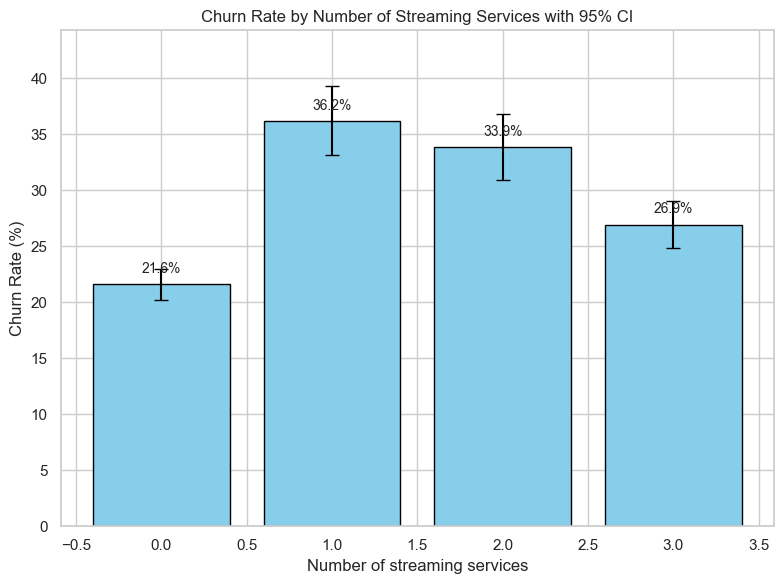

In [50]:
grouped = df.groupby('Streaming Services')['Churn'].agg(['count', 'mean']).reset_index()
grouped['churn_rate'] = grouped['mean'] * 100

z = norm.ppf(0.975)
grouped['SE'] = np.sqrt(grouped['mean'] * (1 - grouped['mean']) / grouped['count'])
grouped['CI_lower'] = (grouped['mean'] - z * grouped['SE']).clip(lower=0) * 100
grouped['CI_upper'] = (grouped['mean'] + z * grouped['SE']).clip(upper=1) * 100
grouped['error'] = grouped['CI_upper'] - grouped['churn_rate']

plt.figure(figsize=(8,6))
plt.bar(grouped['Streaming Services'], grouped['churn_rate'], 
        yerr=grouped['error'], capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Number of streaming services')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by Number of Streaming Services with 95% CI')
plt.ylim(0, grouped['CI_upper'].max() + 5)

for i, row in grouped.iterrows():
    plt.text(row['Streaming Services'], row['churn_rate'] + 1, f"{row['churn_rate']:.1f}%", 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

- There is no clear independent pattern based on the number of streaming services or combinations of services.

In [51]:
cols = ['Streaming Services', "Streaming TV",
    "Streaming Movies",
    "Streaming Music", 'Churn']

corr_matrix = df[cols].corr(method='spearman') 

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

- The correlation matrix does not show strong results for streaming combinations.  
- Therefore, we assume that streaming services do **not have a significant impact** on customer churn.

## 📌 Insights

- The type of service (**Internet** or **Phone**) has a significant impact on customer churn.  

- There is no noticeable relationship between the **amount of used GB** and customer churn.  
- **Online Security** and **Premium Technical Support** individually have a clear impact on churn.  
- Streaming services do **not have a significant impact** on customer churn.
---

# 💔Top 3 reasons of churn

In [52]:
sns.countplot(
    y='Churn Reason',
    data=df,
    order=df['Churn Reason'].value_counts().index
)
plt.show()

reason_counts = df['Churn Reason'].value_counts()

total_churn = reason_counts.sum()

top_3 = reason_counts.head(3)
top_3_percent = (top_3.sum() / total_churn) * 100

print(f"Top 3 churn reasons cover {top_3_percent:.2f}% of all churned customers.")

Top 3 churn reasons cover 45.16% of all churned customers.


- The top churn reason is that **competitors have better devices**, closely followed by **competitors make better offers**.  

- The third most common reason is **poor customer service attitude**.  
- Together, these three reasons account for **45.16%** of all churned customers.

Unfortunately, in this analysis we do not have data on **competitors’ offers or devices**, which requires additional data collection.  
We also do not have detailed data on **customer service quality**, so this factor cannot be analyzed further here.

---

# ⚙️Summary for modeling

- **Tenure** is a strong predictor: longer customer relationships reduce churn risk.  

- **Senior Citizens** have a higher churn rate
- **Number of Referrals** and **Number of Dependents** are useful numeric features correlated with lower churn. 
- Customers on **month-to-month contracts** churn significantly more often.   
- The type of service (**Internet** vs. **Phone**) significantly impacts churn individually.  
- **Online Security** and **Premium Technical Support** services reduce churn individually.  
---

# 🤖Modeling

## Data Preparation

- Numeric features are scaled using **StandardScaler** to normalize their values.  

- The categorical feature (**Contract**) is encoded using **OneHotEncoder** to convert categories into binary columns.  
- The dataset is split into training (75%) and testing (25%) sets, keeping the churn class distribution balanced with **stratify=y**.  
- We use **StratifiedKFold** cross-validation with 5 folds to evaluate the model reliably across different subsets of data.

In [53]:
# X based on the most important features identified in the EDA summary above.

X = df[[
    'Tenure in Months', 'Senior Citizen', 'Number of Referrals',
    'Number of Dependents', 'Contract', 'Internet Service',
    'Phone Service', 'Online Security', 'Premium Tech Support'
]]
y = df['Churn']

num_features = [
    'Tenure in Months', 'Number of Referrals', 'Number of Dependents',
    'Internet Service', 'Phone Service', 'Online Security',
    'Premium Tech Support'
]
cat_features = ['Contract']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [54]:
def evaluate_model(model, model_name="Model"):
    """
    Model evaluation:
    - Confusion matrix
    - ROC curve
    - PR curve
    - Main metrics
    Uses global X_test, y_test.
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], cmap='Blues', colorbar=False)
    axes[0].set_title(f'Confusion Matrix ({model_name})')
    axes[0].grid(False)

    # ROC
    RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=axes[1])
    axes[1].set_title(f'ROC Curve ({model_name})')

    # PR
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=axes[2])
    axes[2].set_title(f'Precision-Recall Curve ({model_name})')

    plt.tight_layout()
    plt.show()

    # Metrics
    print(f"=== Metrics for {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("MCC:", matthews_corrcoef(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print("PR-AUC:", average_precision_score(y_test, y_pred_proba))
    print("Brier Score:", brier_score_loss(y_test, y_pred_proba))

In [55]:

# === Logistic Regression =============================================================
# Build a pipeline: preprocessing + logistic regression
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Define hyperparameter grid for logistic regression
param_grid_logreg = {
    'logreg__C': [0.01, 0.1, 1, 10],                # Regularization strength
    'logreg__penalty': ['l1', 'l2'],                # Type of regularization
    'logreg__solver': ['liblinear'],                # Solver that supports l1/l2
    'logreg__class_weight': ['balanced']            # Handle class imbalance
}

# Grid search with cross-validation for logistic regression
grid_logreg = GridSearchCV(
    pipe_logreg, param_grid_logreg, scoring='average_precision', cv=cv
)
grid_logreg.fit(X_train, y_train)

# Output best hyperparameters and PR-AUC score
print("Best params (LogReg):", grid_logreg.best_params_)
print("Best PR-AUC (LogReg):", grid_logreg.best_score_)


# === Decision Tree =============================================================
# Build a pipeline: preprocessing + decision tree
pipe_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

# Define hyperparameter grid for decision tree
param_grid_tree = {
    'classifier__max_depth': [3, 5, 10, None],      # Tree depth
    'classifier__min_samples_split': [2, 5, 10]     # Min samples to split a node
}

# Grid search with cross-validation for decision tree
grid_tree = GridSearchCV(
    pipe_tree, param_grid_tree, scoring='average_precision', cv=cv
)
grid_tree.fit(X_train, y_train)

# Output best hyperparameters and PR-AUC score
print("Best params (Tree):", grid_tree.best_params_)
print("Best PR-AUC (Tree):", grid_tree.best_score_)


# === Random Forest =============================================================
# Build a pipeline: preprocessing + random forest
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Define hyperparameter grid for random forest
param_grid_rf = {
    'classifier__n_estimators': [50, 100],              # Number of trees
    'classifier__max_depth': [5, 10, None],             # Max tree depth
    'classifier__min_samples_split': [2, 5, 10],        # Min samples to split a node
    'classifier__max_features': ['sqrt', 'log2', None]  # Number of features to consider at each split
}

# Grid search with cross-validation for random forest (parallelized)
grid_rf = GridSearchCV(
    pipe_rf, param_grid_rf, scoring='average_precision', cv=cv, n_jobs=-1
)
grid_rf.fit(X_train, y_train)

# Output best hyperparameters and PR-AUC score
print("Best params (RF):", grid_rf.best_params_)
print("Best PR-AUC (RF):", grid_rf.best_score_)


# === SVM ====================================================================
# Build a pipeline: preprocessing + SVM
pipe_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC(probability=True))    # probability=True for predict_proba
])

# Define hyperparameter grid for SVM
param_grid_svm = {
    'svm__C': [0.1, 1, 10],                      # Regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly'],    # Kernel type
    'svm__degree': [2, 3, 4],                    # Degree for poly kernel
    'svm__class_weight': ['balanced']            # Handle class imbalance
}

# Grid search with cross-validation for SVM
grid_svm = GridSearchCV(
    pipe_svm, param_grid_svm, scoring='average_precision', cv=cv
)
grid_svm.fit(X_train, y_train)

# Output best hyperparameters and PR-AUC score
print("Best params (SVM):", grid_svm.best_params_)
print("Best PR-AUC (SVM):", grid_svm.best_score_)


# === AdaBoost + SMOTE =============================================================
# Build a pipeline: preprocessing + SMOTE oversampling + AdaBoost
pipe_ada = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),                   # Handle class imbalance by oversampling
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Define hyperparameter grid for AdaBoost
param_grid_ada = {
    'classifier__n_estimators': [50, 100, 150, 200],     # Number of weak learners
    'classifier__learning_rate': [0.01, 0.1, 0.5, 1],    # Learning rate
    'classifier__algorithm': ['SAMME', 'SAMME.R']        # AdaBoost algorithm variant
}

# Grid search with cross-validation for AdaBoost + SMOTE
grid_ada = GridSearchCV(
    pipe_ada, param_grid_ada, scoring='average_precision', cv=cv
)
grid_ada.fit(X_train, y_train)

# Output best hyperparameters and PR-AUC score
print("Best params (AdaBoost):", grid_ada.best_params_)
print("Best PR-AUC (AdaBoost):", grid_ada.best_score_)


# === LightGBM =============================================================
# Calculate scale_pos_weight for LightGBM (not used here, but often useful)
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Build a pipeline: preprocessing + LightGBM
pipe_lgb = Pipeline([
    ('preprocessor', preprocessor),
    ('lgb', lgb.LGBMClassifier(random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid for LightGBM
param_grid_lgb = {
    'lgb__n_estimators': [100, 200],                # Number of boosting rounds
    'lgb__learning_rate': [0.01, 0.1, 0.2],         # Learning rate
    'lgb__max_depth': [3, 5, -1],                   # Max tree depth (-1 means no limit)
    'lgb__verbose': [-1]                            # Suppress LightGBM output
}

# Grid search with cross-validation for LightGBM
grid_lgb = GridSearchCV(
    pipe_lgb, param_grid_lgb, scoring='average_precision', cv=cv
)
grid_lgb.fit(X_train, y_train)

# Output best hyperparameters and PR-AUC score
print("Best params (LightGBM):", grid_lgb.best_params_)
print("Best PR-AUC (LightGBM):", grid_lgb.best_score_)


Best params (LogReg): {'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best PR-AUC (LogReg): 0.6495430353210154
Best params (Tree): {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Best PR-AUC (Tree): 0.6241790626401643
Best params (RF): {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best PR-AUC (RF): 0.707964312272048
Best params (SVM): {'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__degree': 2, 'svm__kernel': 'rbf'}
Best PR-AUC (SVM): 0.6616734643468901
Best params (AdaBoost): {'classifier__algorithm': 'SAMME', 'classifier__learning_rate': 1, 'classifier__n_estimators': 200}
Best PR-AUC (AdaBoost): 0.7043927947043871
Best params (LightGBM): {'lgb__learning_rate': 0.1, 'lgb__max_depth': 3, 'lgb__n_estimators': 100, 'lgb__verbose': -1}
Best PR-AUC (LightGBM): 0.7142627978942835


In [56]:
# === Best base models =============================================================
rf_best = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

lgbm_best = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    class_weight='balanced',
    verbose=-1,
    random_state=42
)

svm_best = SVC(
    probability=True,
    kernel='rbf',
    degree=2,
    C=1,
    class_weight='balanced',
    random_state=42
)

# === Meta-model ===
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# === Stacking ===
pipe_stack = Pipeline([
    ('preprocessor', preprocessor),
    ('stack', StackingClassifier(
        estimators=[
            ('rf', rf_best),
            ('lgbm', lgbm_best),
            ('svm', svm_best)
        ],
        final_estimator=meta_model,
        cv=5,
        stack_method='predict_proba',  # important for PR-AUC
        n_jobs=-1
    ))
])

# === Cross-validation ===
grid_stack = GridSearchCV(
    pipe_stack,
    param_grid={},  # hyperparameters already selected
    scoring='average_precision',
    cv=cv
)
grid_stack.fit(X_train, y_train)
print("Best PR-AUC (Stacking):", grid_stack.best_score_)

Best PR-AUC (Stacking): 0.7158994623418681


## Modeling Summary

- **Individual Model Performance (PR‑AUC):**  
  - Logistic Regression: 0.650  
  - Decision Tree: 0.624  
  - Random Forest: 0.708  
  - AdaBoost: 0.704  
  - SVM: 0.662  
  - LightGBM: 0.714  

- **Stacking Ensemble:**  
  - Base learners: Random Forest, LightGBM, SVM  
  - Meta‑model: Logistic Regression  
  - Cross‑validated PR‑AUC: **0.715**  

The stacking ensemble slightly outperforms all single models, demonstrating that combining diverse algorithms can improve churn‑prediction performance.  


## Final Metrics

In [57]:
# evaluate_model(grid_logreg, model_name="Logistic Regression")
# evaluate_model(grid_tree, model_name="Decision Tree")
# evaluate_model(grid_rf, model_name="Random Forest")
# evaluate_model(grid_svm, model_name="SVM")
# evaluate_model(grid_ada, model_name="AdaBoost + SMOTE")
# evaluate_model(grid_lgb, model_name="LightGBM")

evaluate_model(grid_stack, model_name="Stacking")


=== Metrics for Stacking ===
Accuracy: 0.7995457126632595
Balanced Accuracy: 0.8177554782574161
F1 Score: 0.6938421509106678
MCC: 0.5752840469285961
Recall: 0.8565310492505354
Precision: 0.5830903790087464
ROC-AUC: 0.8930924808620913
PR-AUC: 0.7447670928314555
Brier Score: 0.13790517864550464


- **Recall / Sensitivity (0.86)**  
  - Fraction of actual churners correctly identified (few false negatives).  
  - High recall ensures most at‑risk customers are flagged for retention efforts.

- **Balanced Accuracy (0.82)**  
  - Average of recall for both churn and non‑churn classes.  
  - Indicates the model handles class imbalance well without bias toward the majority.

- **Precision (0.58)**  
  - Of all customers predicted to churn, 58% actually do.  
  - Highlights that ~42% of flagged customers are false positives, which may waste retention resources.

- **F1 Score (0.69)**  
  - Harmonic mean of precision and recall.  
  - Balances the trade‑off: 0.69 suggests room to improve reducing false positives while maintaining high recall.

- **Matthews Correlation Coefficient (MCC) (0.58)**  
  - Single metric combining true/false positives and negatives.  
  - 0.58 reflects moderate overall prediction quality.

- **ROC‑AUC (0.89)**  
  - Measures model’s ability to rank churners above non‑churners across thresholds.  
  - 0.89 demonstrates strong separability.

- **PR‑AUC (0.74)**  
  - Area under the Precision‑Recall curve, focusing on the positive (churn) class.  
  - More informative than ROC‑AUC on imbalanced data.  
  - 0.74 is solid, especially given class imbalance.

- **Brier Score (0.14)**  
  - Mean squared error of predicted probabilities (0 is perfect, 1 is worst).  
  - 0.14 shows reasonably well‑calibrated probabilities.
---

**Strong Points:**  
- **High recall (0.86)** ensures most churners are caught.  
- **ROC‑AUC (0.89)** and **Balanced Accuracy (0.82)** indicate robust discrimination even on an imbalanced dataset.  
- **Low Brier Score (0.14)** confirms good probability estimates.  


**Where to Improve:**  
- **Precision & F1:** Precision (0.58) and F1 (0.69) lag behind recall, suggesting the model flags too many false positives.


## Permutation Feature Importance

- Permutation importance measures how much the model’s performance metric decreases when a feature’s values are randomly shuffled.

- Here we use **PR‑AUC** (`average_precision`) on the test set to evaluate importance.
- Features that cause a larger drop in PR‑AUC when permuted are more important.

In [58]:
# Get best model and its components
best_model = grid_stack.best_estimator_
preprocessor = best_model.named_steps['preprocessor']
stack_model = best_model.named_steps['stack']

# Transform test set
X_test_transformed = preprocessor.transform(X_test)

# Permutation importance with PR-AUC
result = permutation_importance(
    stack_model,
    X_test_transformed,
    y_test,
    n_repeats=10,
    scoring='average_precision',
    random_state=1
)

# Feature names
num_names = num_features
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = list(num_names) + list(cat_names)

# DataFrame of importances
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Permutation Importance': result.importances_mean
}).sort_values(by='Permutation Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Permutation Importance'], color='skyblue')
plt.xlabel('Importance')
plt.show()

## Top 5 Features Driving Churn (and Conclusions)

1. **Number of Referrals**  
   - **Why it matters:** Customers who refer friends tend to be more engaged and loyal.  
   - **Actionable insight:**  
     - Expand referral incentives (e.g., bonus months for both referrer and referee).  
     - Highlight referral programs in onboarding and billing communications.

2. **Month‑to‑Month Contract**  
   - **Why it matters:** Customers on flexible, short-term plans can leave at any time.  
   - **Actionable insight:**  
     - Offer discounts or added perks for customers who upgrade to 6‑ or 12‑month contracts.  

3. **Internet Service**  
   - **Why it matters:** Internet users churn differently than phone‑only customers—likely due to service quality issues.  
   - **Actionable insight:**  
     - Monitor and proactively address speed or uptime complaints.  
     - Keep track of competitors’ internet offers to stay competitive with pricing and features.  

4. **Number of Dependents**  
   - **Why it matters:** Customers with dependents (families) are more stable—likely because multiple household members rely on the service.  
   - **Actionable insight:**  
     - Create family‑focused plans (e.g., “add a line” at reduced cost).  
     - Market multi‑device security or content bundles tailored to households.

5. **Tenure (Months with Company)**  
   - **Why it matters:** Longer tenure correlates with lower churn rate over time.  
   - **Actionable insight:**  
     - Launch milestone rewards (e.g., gift cards or service credits at 6‑, 12‑, 24‑month anniversaries).  
     - Send periodic “thank you” offers or exclusive upgrades to long‑standing customers.

---


Dont foget about reasons that come directly from what customers who churned have reported. 

- Competitors have better devices
- Competitors make better offers
- Poor customer service attitude

It’s important not to overlook them. To reduce churn, the company should:

- Regularly collect and analyze customer feedback to identify service weaknesses.

- Conduct ongoing research on competitors’ devices and offers to stay competitive.
- Collaborate with marketing agencies, especially in cities with high churn rates like San Diego, San Francisco, Escondido, to tailor targeted campaigns and retention strategies.

---

***Thanks for reading!***
